## Importing necessary libraries and data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt

%matplotlib inline

import seaborn as sns

sns.set_theme()

# to perform k-means clustering and compute silhouette scores and standard scaling
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# to scale data using zscores and compute distances
from scipy.stats import zscore
from scipy.spatial.distance import cdist

# this will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

<IPython.core.display.Javascript object>

## Data Overview

- Observations
- Sanity checks

In [2]:
# load the data set
stockdata = pd.read_csv("stock_data.csv")

<IPython.core.display.Javascript object>

In [3]:
stockdata.shape

(340, 15)

<IPython.core.display.Javascript object>

In [4]:
stockdata.sample(n=10, random_state=1)

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
102,DVN,Devon Energy Corp.,Energy,Oil & Gas Exploration & Production,32.000000,-15.478079,2.923698,205,70,830000000,-14454000000,-35.55,4.065823e+08,93.089287,1.785616
125,FB,Facebook,Information Technology,Internet Software & Services,104.660004,16.224320,1.320606,8,958,592000000,3669000000,1.31,2.800763e+09,79.893133,5.884467
11,AIV,Apartment Investment & Mgmt,Real Estate,REITs,40.029999,7.578608,1.163334,15,47,21818000,248710000,1.52,1.636250e+08,26.335526,-1.269332
248,PG,Procter & Gamble,Consumer Staples,Personal Products,79.410004,10.660538,0.806056,17,129,160383000,636056000,3.28,4.913916e+08,24.070121,-2.256747
238,OXY,Occidental Petroleum,Energy,Oil & Gas Exploration & Production,67.610001,0.865287,1.589520,32,64,-588000000,-7829000000,-10.23,7.652981e+08,93.089287,3.345102
336,YUM,Yum! Brands Inc,Consumer Discretionary,Restaurants,52.516175,-8.698917,1.478877,142,27,159000000,1293000000,2.97,4.353535e+08,17.682214,-3.838260
112,EQT,EQT Corporation,Energy,Oil & Gas Exploration & Production,52.130001,-21.253771,2.364883,2,201,523803000,85171000,0.56,1.520911e+08,93.089287,9.567952
147,HAL,Halliburton Co.,Energy,Oil & Gas Equipment & Services,34.040001,-5.101751,1.966062,4,189,7786000000,-671000000,-0.79,8.493671e+08,93.089287,17.345857
89,DFS,Discover Financial Services,Financials,Consumer Finance,53.619999,3.653584,1.159897,20,99,2288000000,2297000000,5.14,4.468872e+08,10.431906,-0.375934
173,IVZ,Invesco Ltd.,Financials,Asset Management & Custody Banks,33.480000,7.067477,1.580839,12,67,412000000,968100000,2.26,4.283628e+08,14.814159,4.218620


<IPython.core.display.Javascript object>

* The data set has 340 rows and 15 columns, so it is not too large.  
* I am seeing some enormeous net losses which is kind of appauling, but not unlikely.  
* Most of the financial measures are inter-related so there is likely good opportunity for dimension reduction.
* I need to fix the column names to eliminate the spaces

## Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

In [37]:
# start by making a copy of the data set
data = stockdata.copy()

<IPython.core.display.Javascript object>

In [38]:
# remove the spaces in the column names
data.columns = [c.replace(" ", "_") for c in data.columns]

<IPython.core.display.Javascript object>

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticker_Symbol                 340 non-null    object 
 1   Security                      340 non-null    object 
 2   GICS_Sector                   340 non-null    object 
 3   GICS_Sub_Industry             340 non-null    object 
 4   Current_Price                 340 non-null    float64
 5   Price_Change                  340 non-null    float64
 6   Volatility                    340 non-null    float64
 7   ROE                           340 non-null    int64  
 8   Cash_Ratio                    340 non-null    int64  
 9   Net_Cash_Flow                 340 non-null    int64  
 10  Net_Income                    340 non-null    int64  
 11  Earnings_Per_Share            340 non-null    float64
 12  Estimated_Shares_Outstanding  340 non-null    float64
 13  P/E_R

<IPython.core.display.Javascript object>

In [40]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

<IPython.core.display.Javascript object>

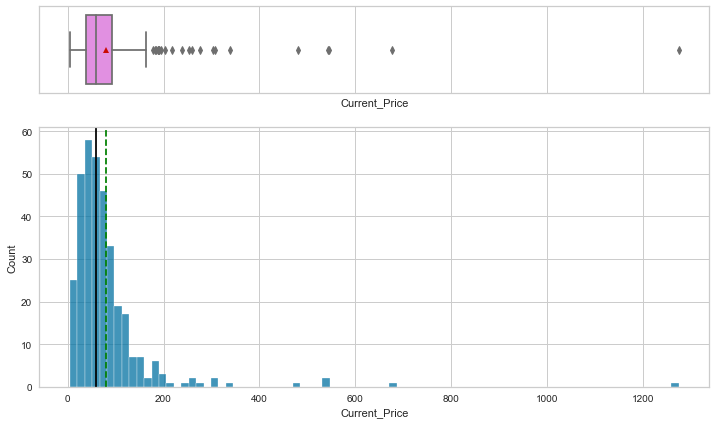

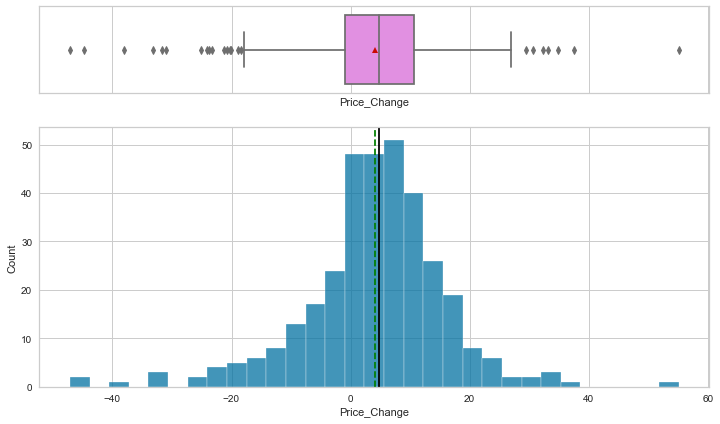

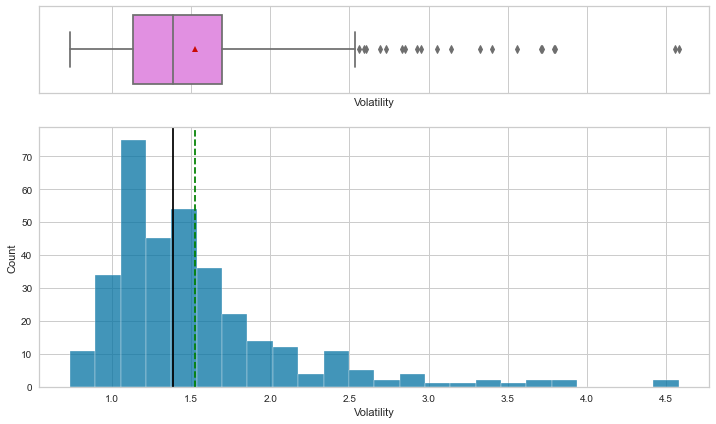

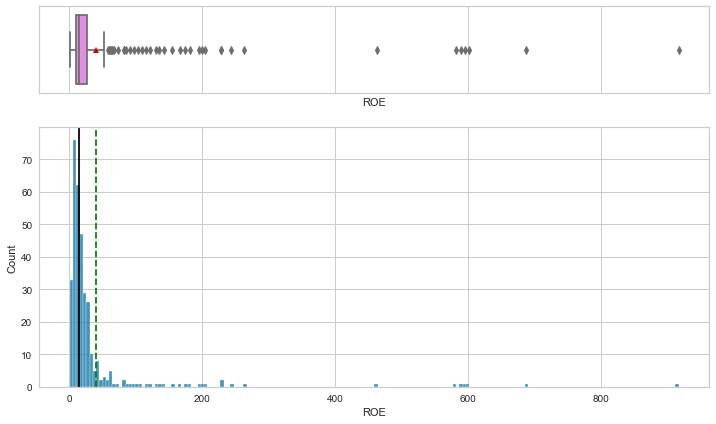

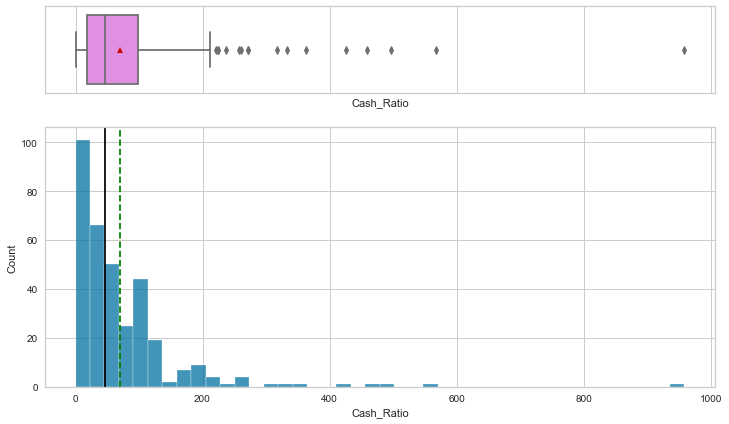

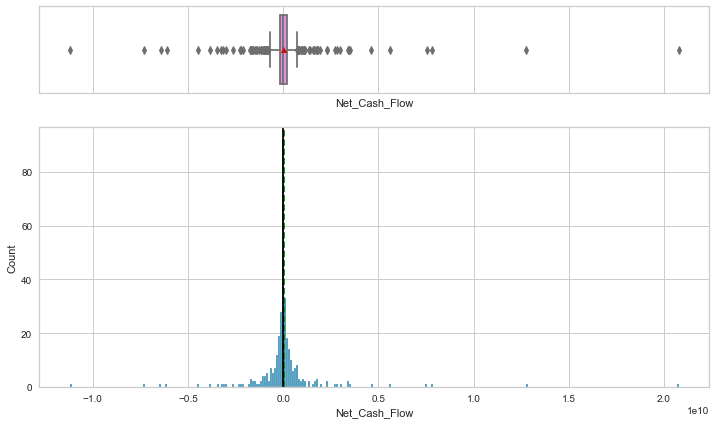

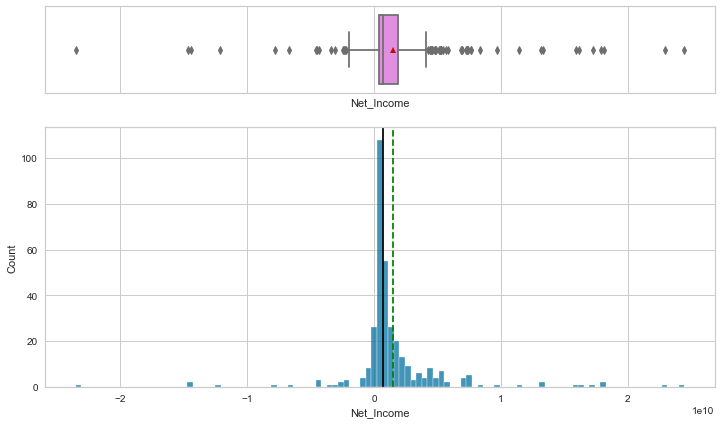

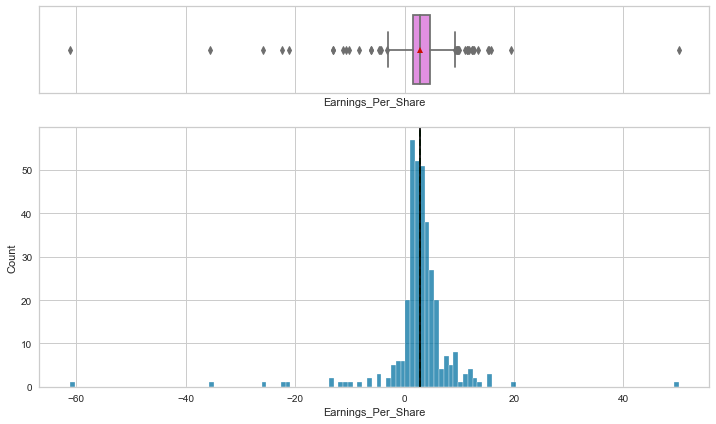

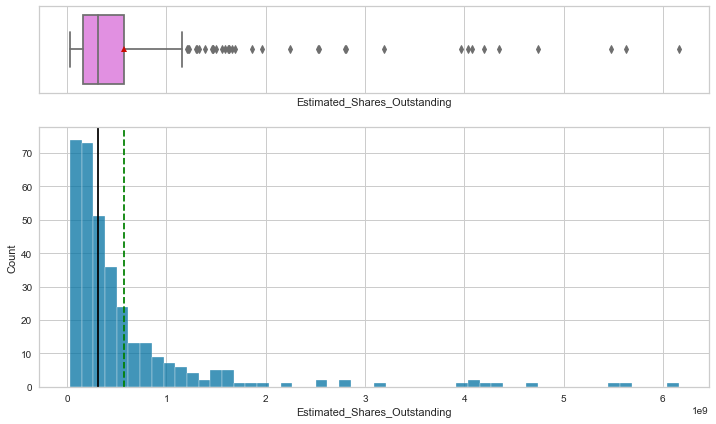

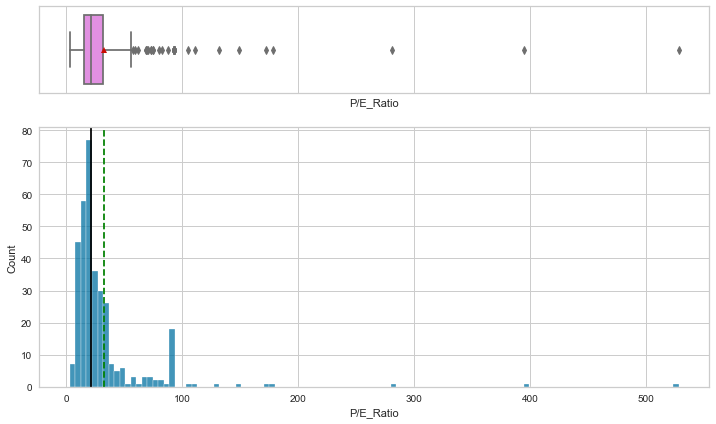

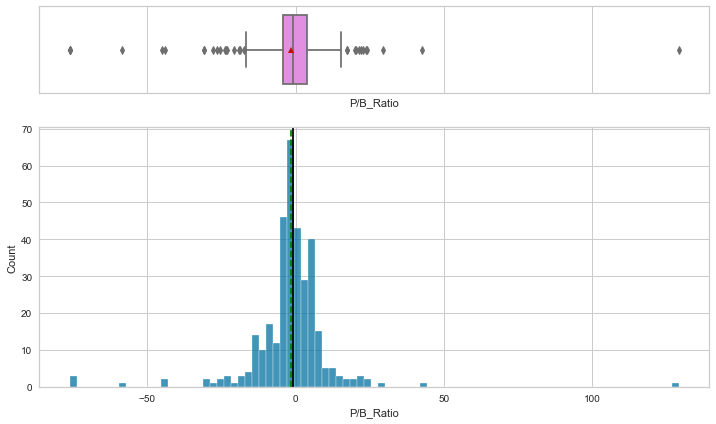

<IPython.core.display.Javascript object>

In [41]:
# graph the numerical columns
num_col = data.select_dtypes(include=np.number).columns.tolist()

for item in num_col:
    histogram_boxplot(data, item)

#### Observations
* Current price is heaviliy right skewed with an extreme outlier
* Price change is rather normally distributed with some outliers
* Volatility is right skewed with outliers
* ROE is heaviliy right skewed with numerous outliers
* Cash Ratio is also very right skewed
* Net Cash Flow, Net Income and Earnings Per Share have a rather normal distribution with a significant number of companies reporting negative Net Cash Flow, Net Income or Earnings Per Share
* Estimated Shares Outstanding and P/E Ratio are both heavily right skewed
* P/B Ratio like Net Cash Flow, Net Income and Earnings Per Share has a rather normal looking distribution with a mean and median close to zero.

In [42]:
# Check how many categories there are for the GICS Sector
data["GICS_Sector"].value_counts()

Industrials                    53
Financials                     49
Health Care                    40
Consumer Discretionary         40
Information Technology         33
Energy                         30
Real Estate                    27
Utilities                      24
Materials                      20
Consumer Staples               19
Telecommunications Services     5
Name: GICS_Sector, dtype: int64

<IPython.core.display.Javascript object>

In [43]:
# Check how many categories there are for the GICS Sub Industry
data["GICS_Sub_Industry"].value_counts()

Oil & Gas Exploration & Production                 16
Industrial Conglomerates                           14
REITs                                              14
Internet Software & Services                       12
Electric Utilities                                 12
Health Care Equipment                              11
MultiUtilities                                     11
Banks                                              10
Property & Casualty Insurance                       8
Biotechnology                                       7
Diversified Financial Services                      7
Semiconductors                                      6
Packaged Foods & Meats                              6
Oil & Gas Refining & Marketing & Transportation     6
Pharmaceuticals                                     6
Diversified Chemicals                               5
Industrial Machinery                                5
Consumer Finance                                    5
Integrated Oil & Gas        

<IPython.core.display.Javascript object>

In [44]:
# creat a function for labeled barplots to explore categorical data


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

<IPython.core.display.Javascript object>

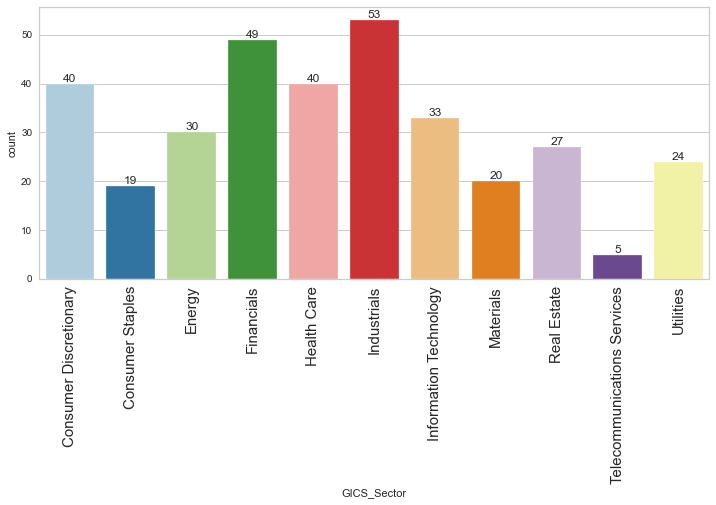

<IPython.core.display.Javascript object>

In [45]:
# Graph the GICS Sector
labeled_barplot(data, "GICS_Sector")

There are 11 GICS Sector categories, and there are numerous records for each category.  Industrials has those most records with 53 and Telecom Services the least with 5.  

In [46]:
# function to plot stacked bar chart so I can get a sense of the sub industries within in each GICS Sector


def stacked_barplot(data, sector, sub):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    sector: GICS Sector
    sub: GICS Sub Industry
    """
    count = data[sector].nunique()
    sorter = data[sub].value_counts().index[-1]
    tab1 = pd.crosstab(data[sector], data[sub], margins=True).sort_values(
        by=sorter, ascending=True
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[sector], data[sub], normalize="index").sort_values(
        by=sorter, ascending=True
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left",
        frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

<IPython.core.display.Javascript object>

GICS_Sub_Industry            Advertising  Aerospace & Defense  \
GICS_Sector                                                     
Consumer Discretionary                 2                    0   
Consumer Staples                       0                    0   
Energy                                 0                    0   
Financials                             0                    0   
Health Care                            0                    0   
Industrials                            0                    4   
Information Technology                 0                    0   
Real Estate                            0                    0   
Telecommunications Services            0                    0   
Utilities                              0                    0   
Materials                              0                    0   
All                                    2                    4   

GICS_Sub_Industry            Agricultural Products  Air Freight & Logistics  \
GICS_Secto

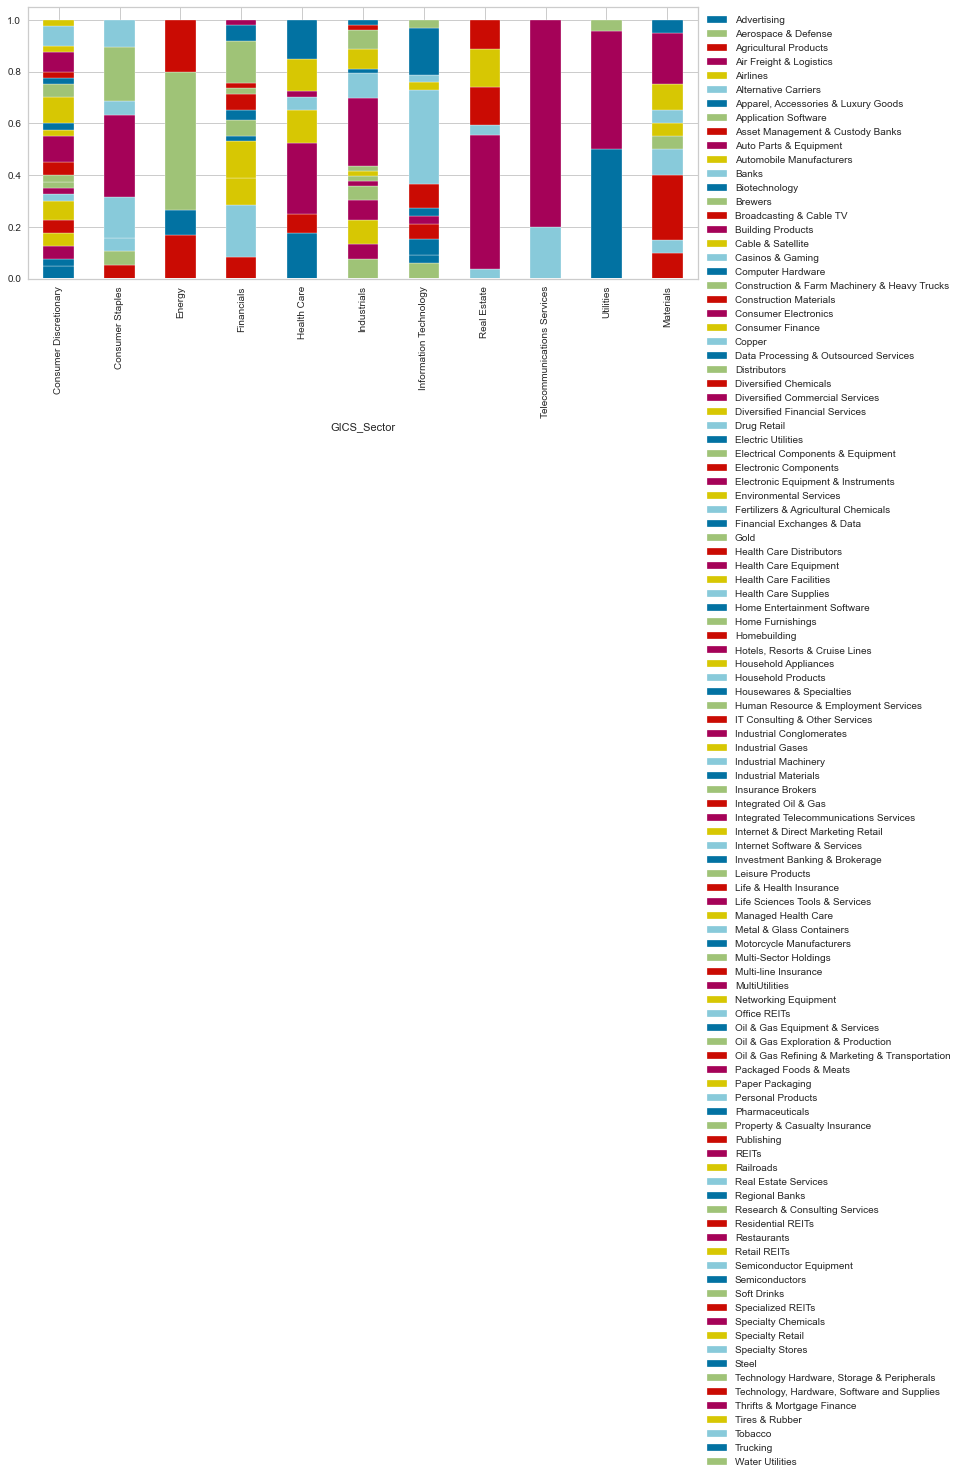

<IPython.core.display.Javascript object>

In [47]:
# Graph the GICS Sector broken out by sub sector
stacked_barplot(data, "GICS_Sector", "GICS_Sub_Industry")

This isn't the best graph but it does give me a sense of the diveristy within in GICS Sector.  I can see that Telecommunications is the least diversified and Consumer Discretionary has the most Sub Categories.

In [48]:
num_col

['Current_Price',
 'Price_Change',
 'Volatility',
 'ROE',
 'Cash_Ratio',
 'Net_Cash_Flow',
 'Net_Income',
 'Earnings_Per_Share',
 'Estimated_Shares_Outstanding',
 'P/E_Ratio',
 'P/B_Ratio']

<IPython.core.display.Javascript object>

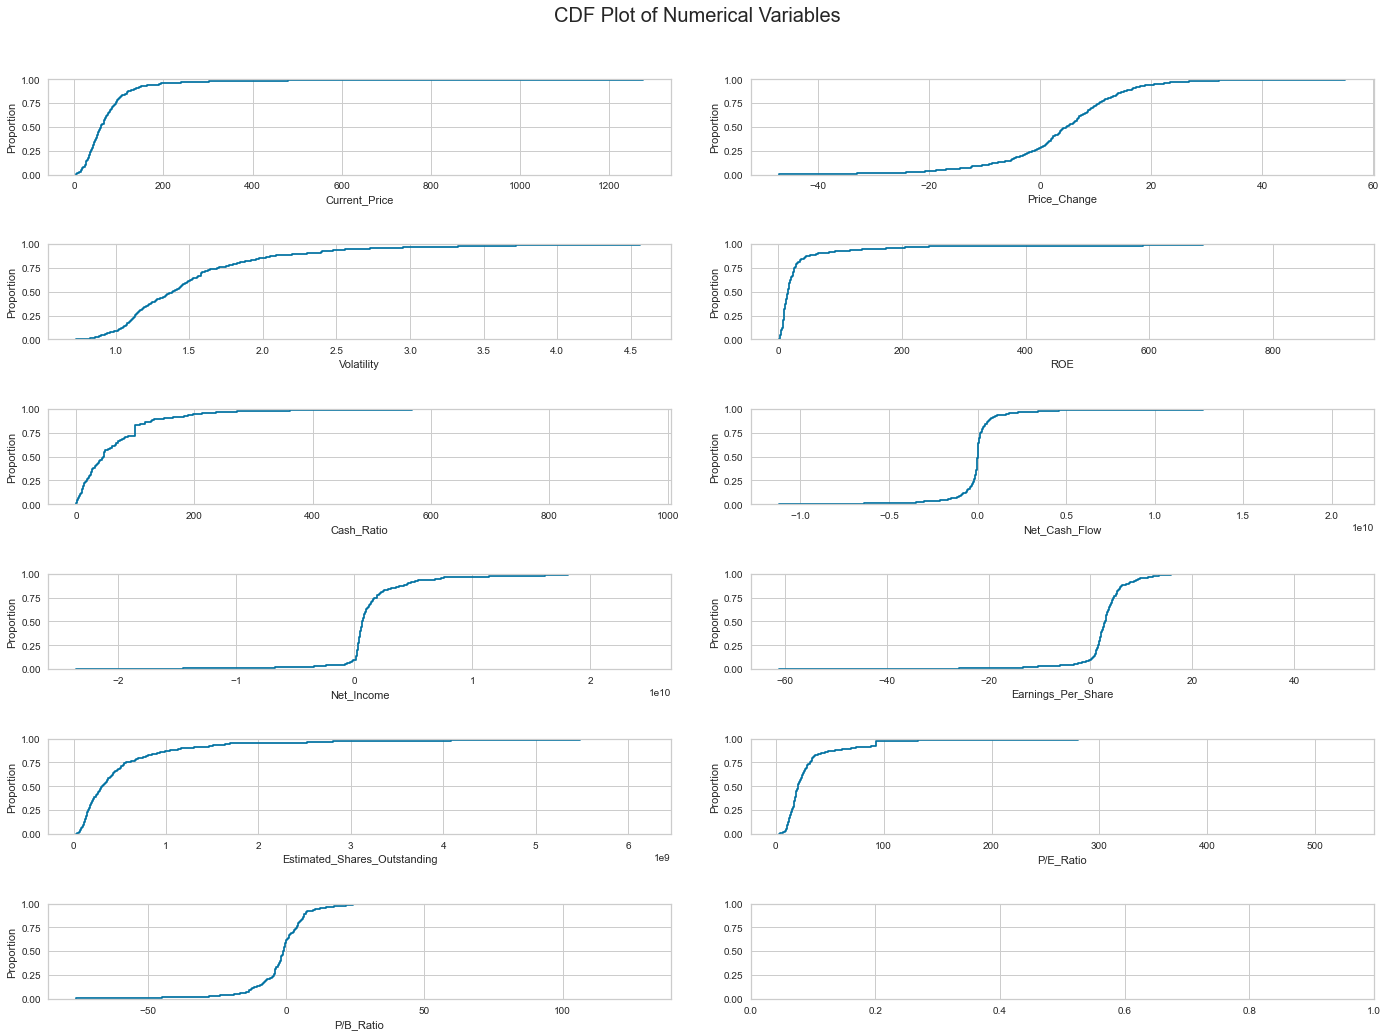

<IPython.core.display.Javascript object>

In [49]:
#  I'll use a CDF Plot to compare the numerical values

fig, axes = plt.subplots(6, 2, figsize=(20, 15))
fig.suptitle("CDF Plot of Numerical Variables", fontsize=20)
counter = 0
for ii in range(6):
    sns.ecdfplot(ax=axes[ii][0], x=data[num_col[counter]])
    counter = counter + 1
    if counter != 11:
        sns.ecdfplot(ax=axes[ii][1], x=data[num_col[counter]])
        counter = counter + 1
    else:
        pass

fig.tight_layout(pad=3.0)

#### Observations
* Over 95% of the companies in this data set have a Current Price less than 200 dollars
* 95% of the companies on this list have had a price change of less than 20 dollars over the last 13 weeks
* Roughly 95% of the companies on this list have a price volatility of 2.5
* Over 95% of the companies on this list are reporting an ROE of at least 200
* Roughly 95% of the companies on this list reported at least 200 Cash Ratio

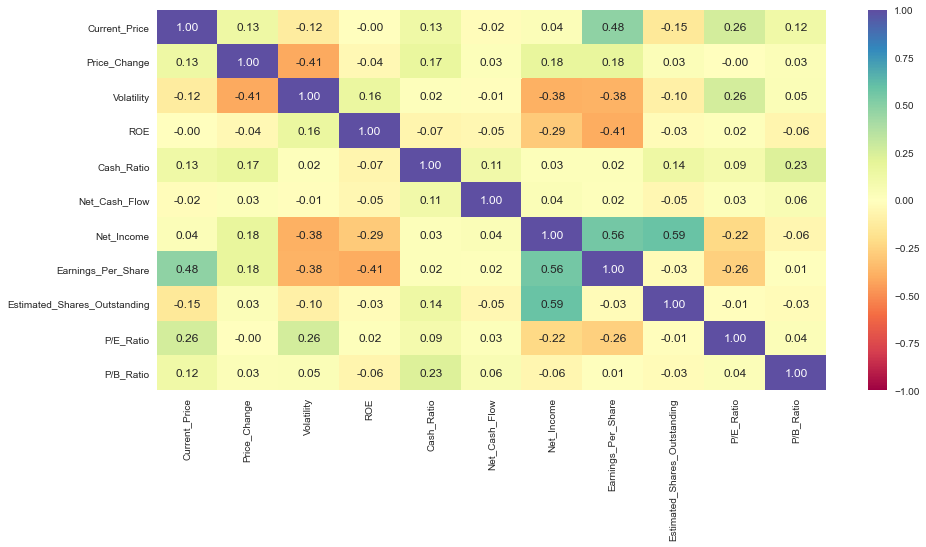

<IPython.core.display.Javascript object>

In [50]:
# Bivariate Analysis - look for correlations
plt.figure(figsize=(15, 7))
sns.heatmap(
    data[num_col].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

#### Observations
* See positive correlations between Current Price and Earnings Per Share
* I see a negative correlation between Volatility and Net Income, Earnings Per Share and Price Change
* I see a negative correlation between ROE and Earnings Per Share
* There is a positive correlation between Net Income and Earnings Per Share and Estimated Shares Outstanding
* There are some additional lesser correlations between other variables

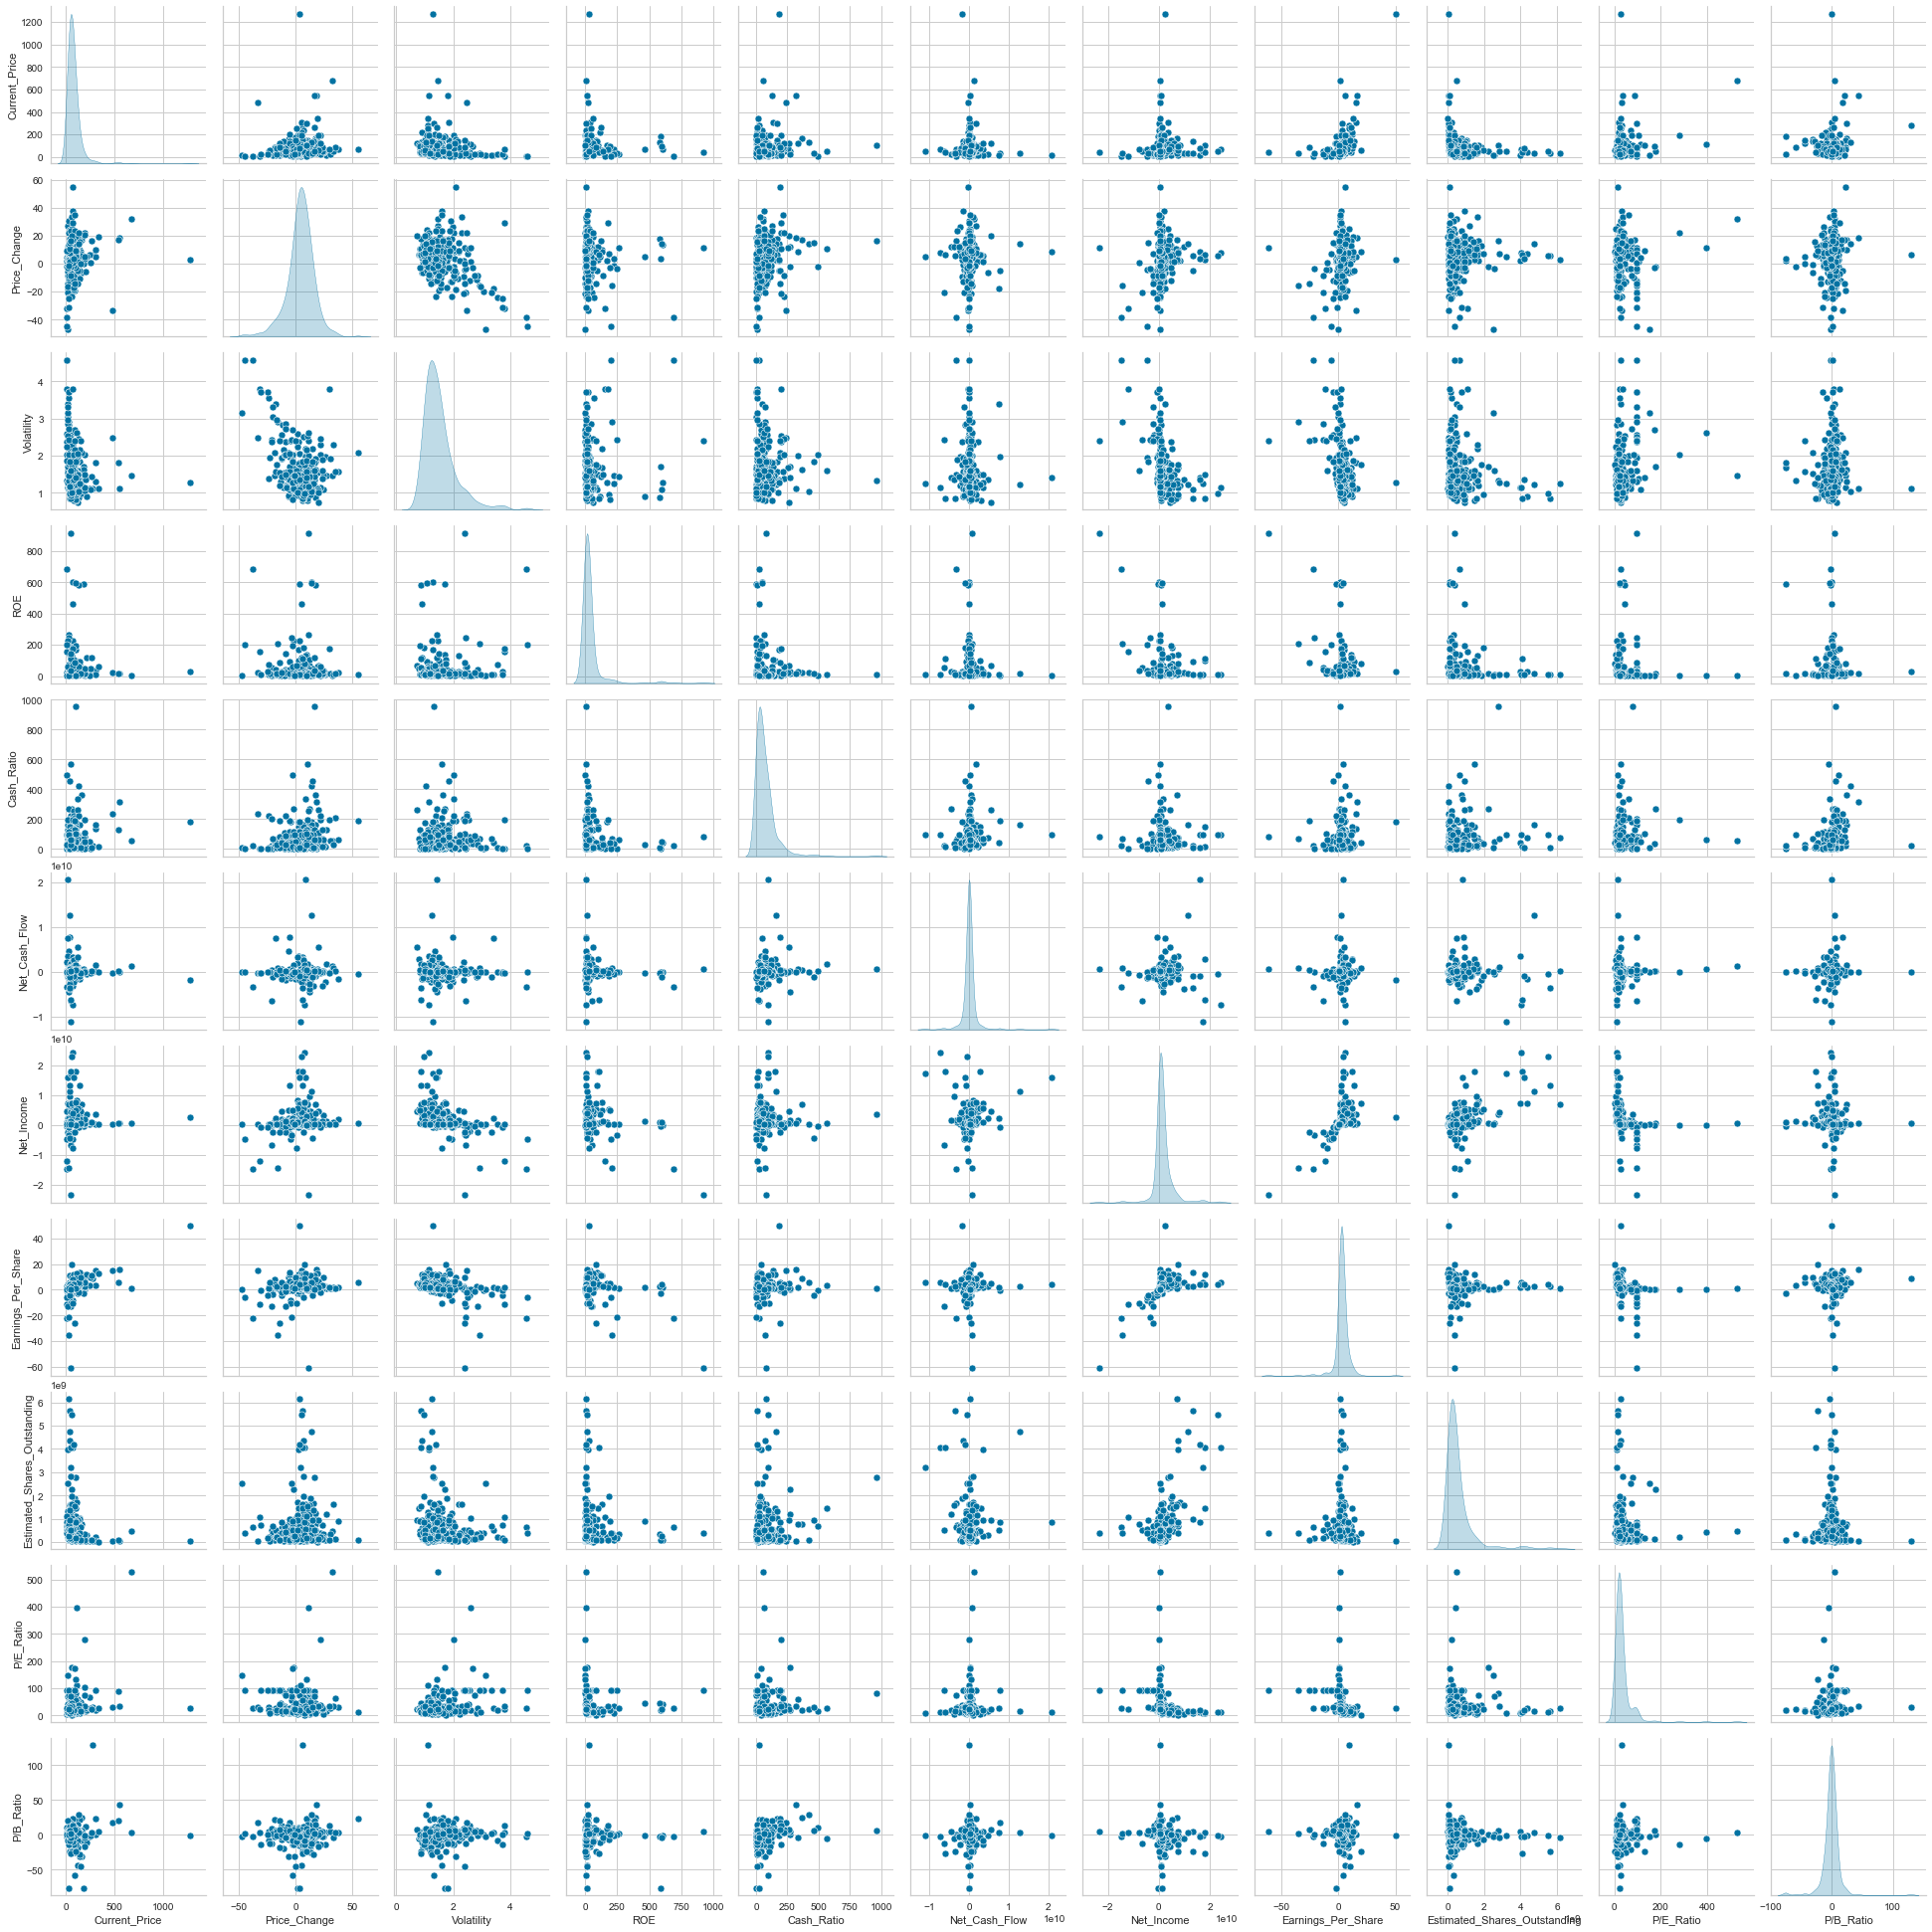

<IPython.core.display.Javascript object>

In [51]:
# Let's look at the pair plot too
sns.pairplot(data=data[num_col], diag_kind="kde")
plt.show()

<Figure size 1080x720 with 0 Axes>

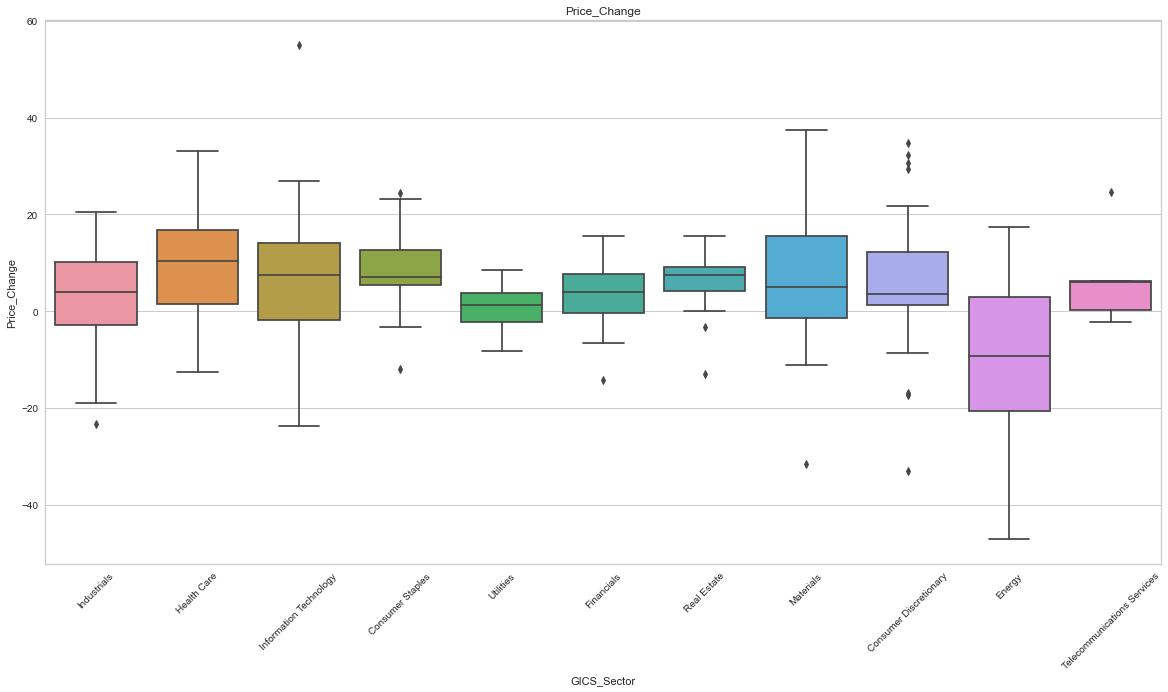

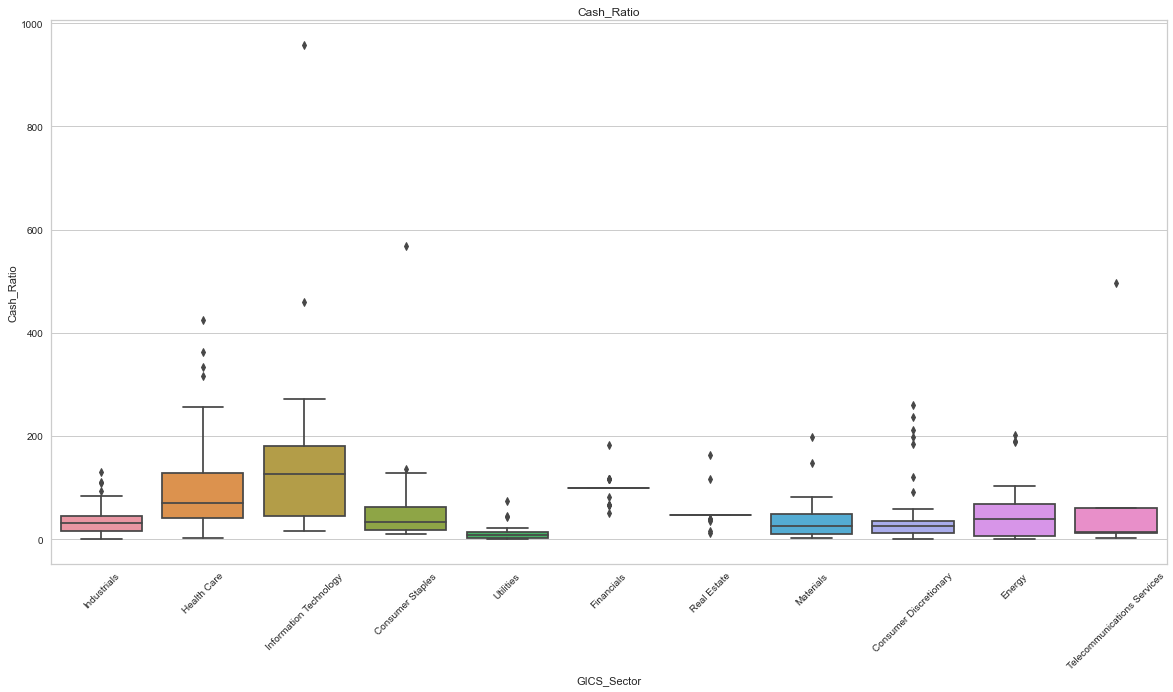

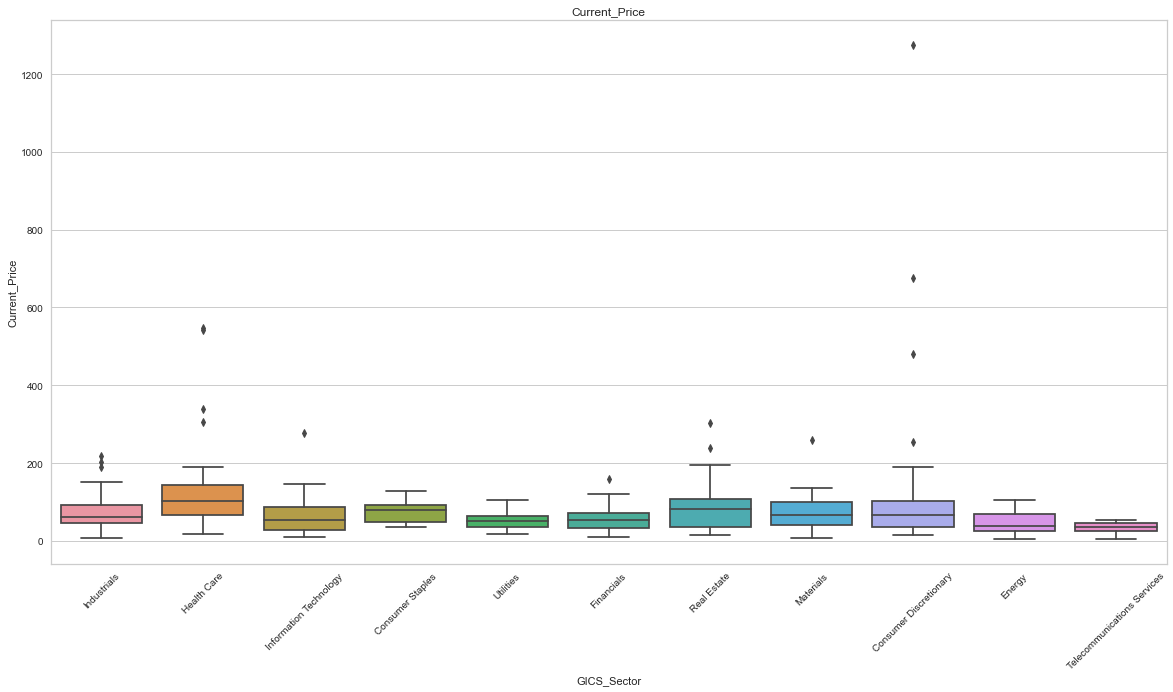

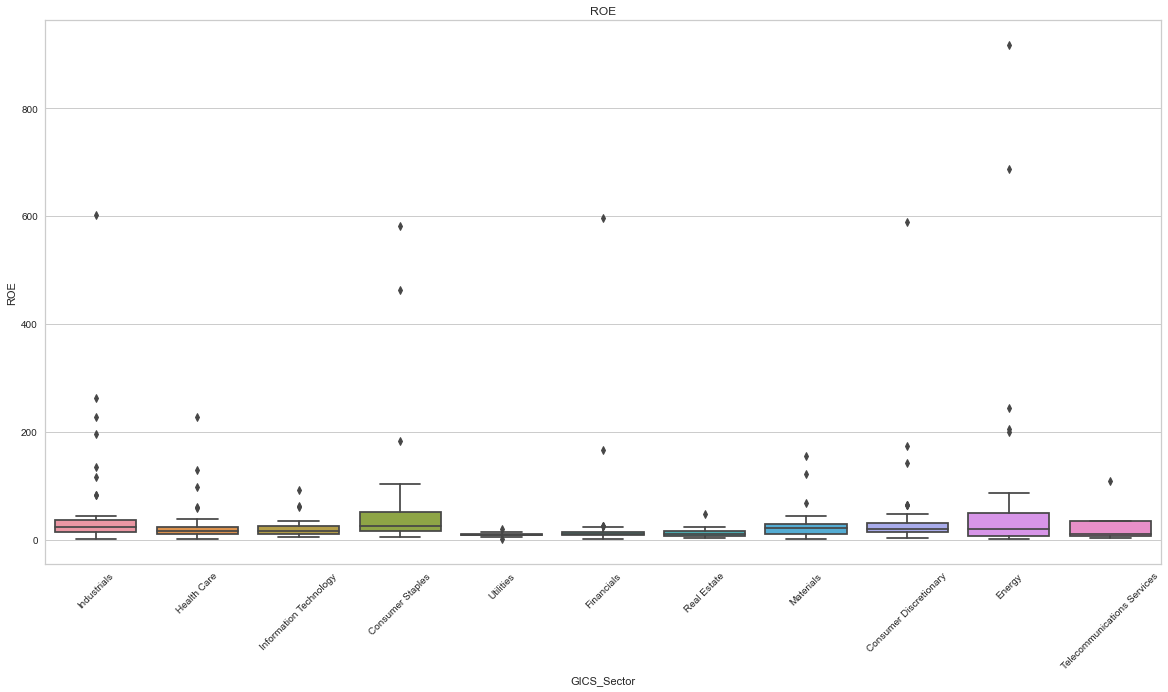

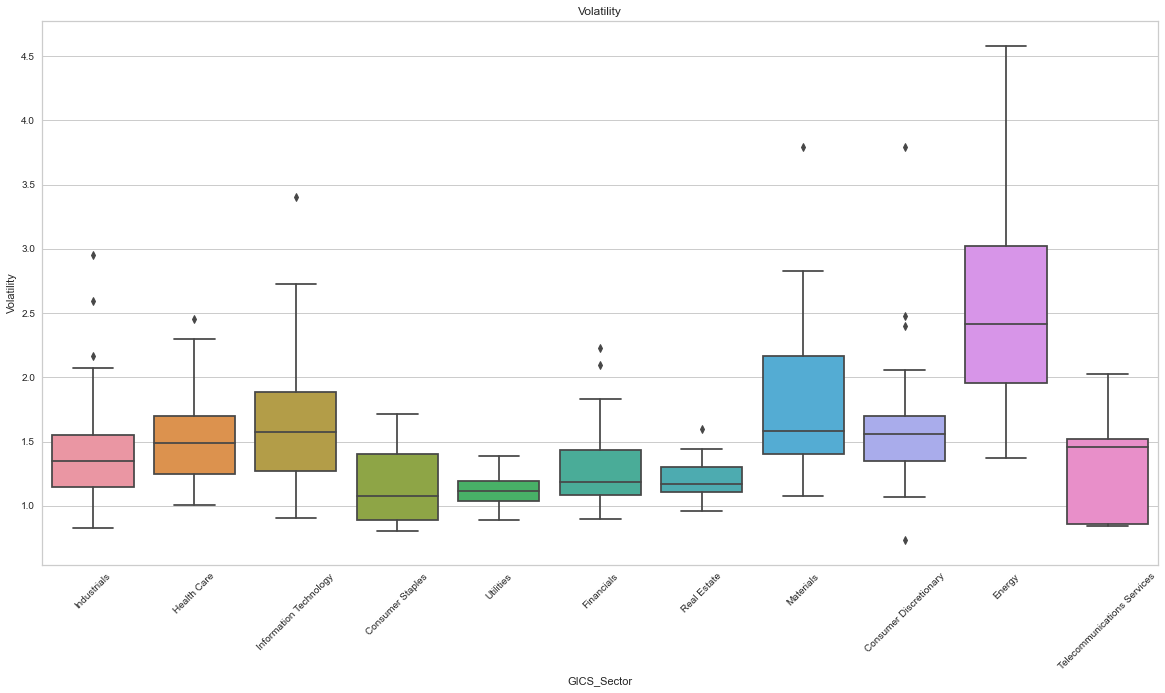

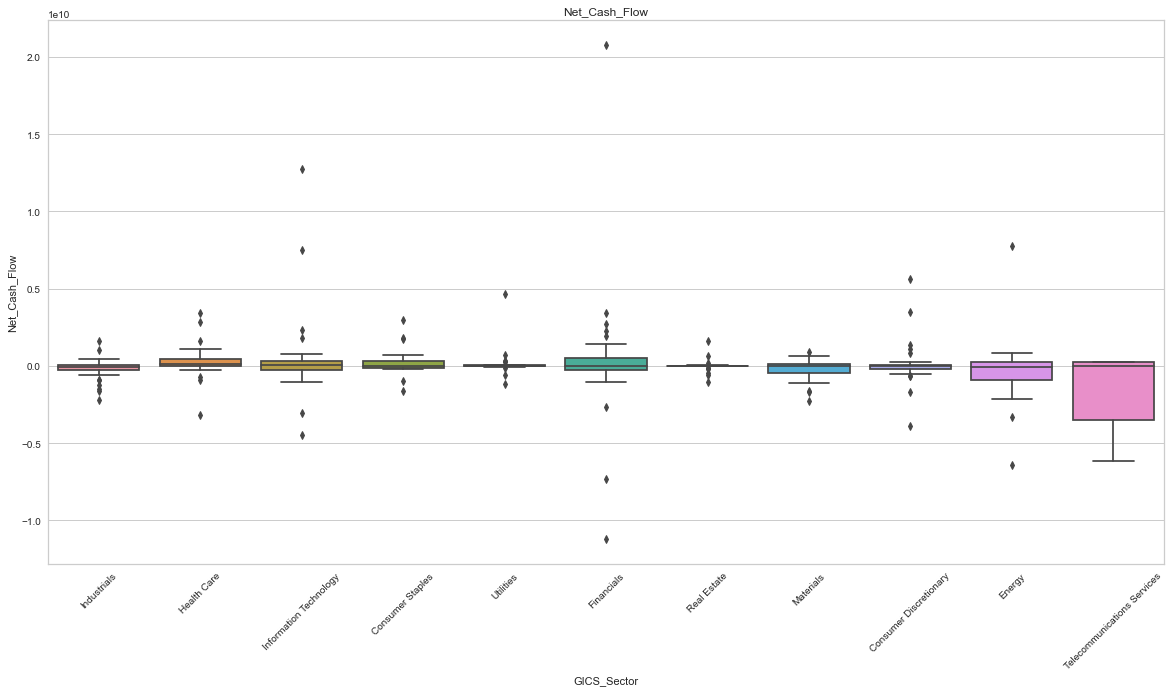

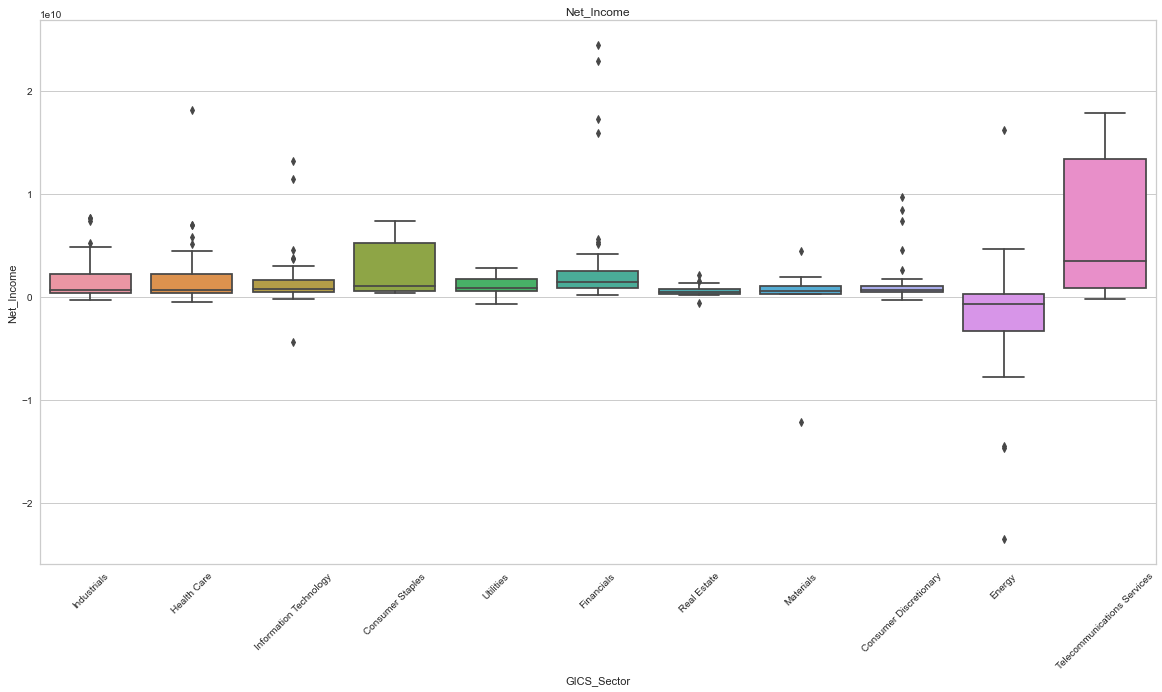

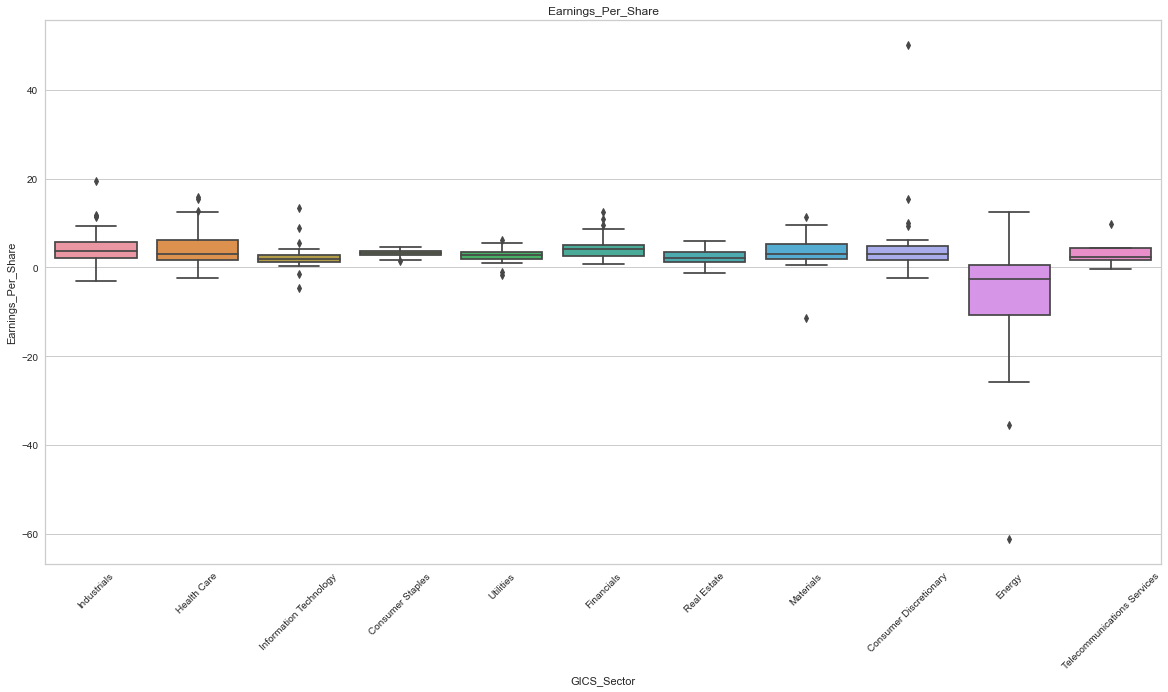

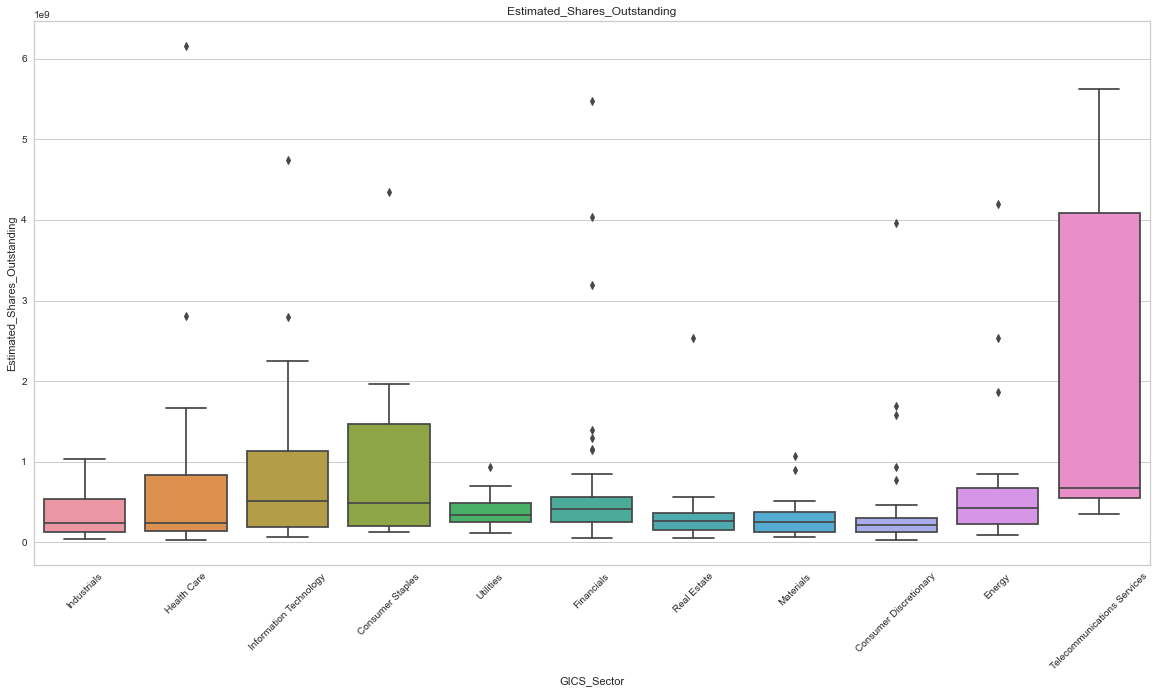

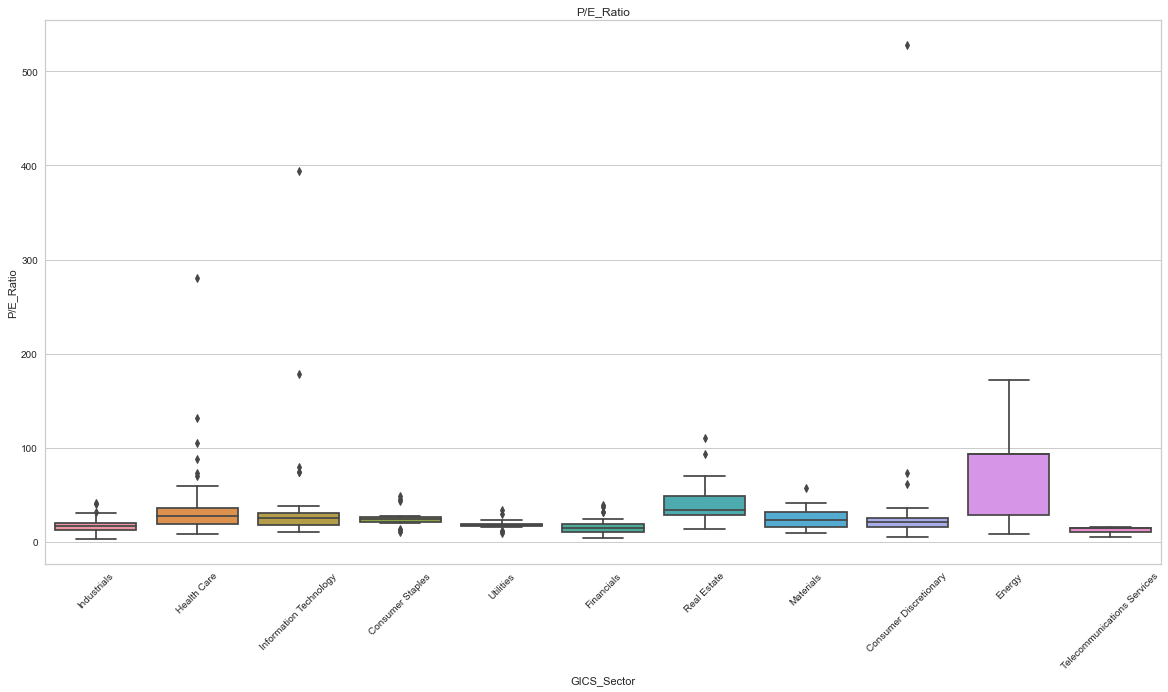

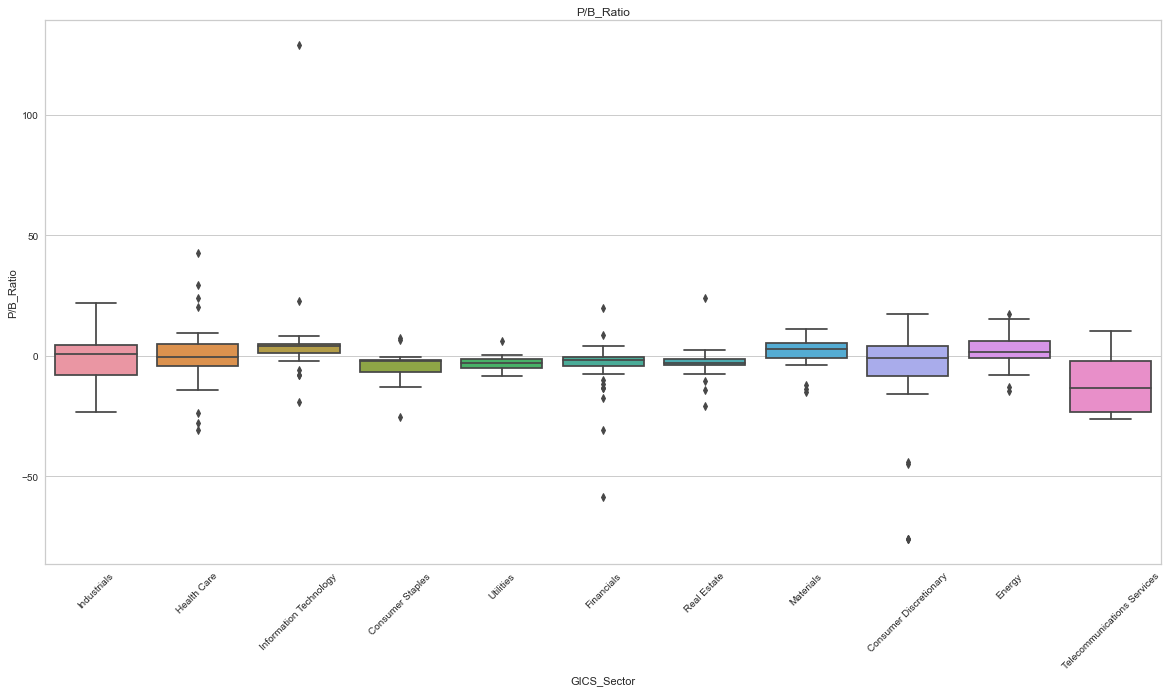

<IPython.core.display.Javascript object>

In [52]:
# Look at the numerical values broken out by economic sector.
cols = data[
    [
        "Price_Change",
        "Cash_Ratio",
        "Current_Price",
        "ROE",
        "Volatility",
        "Net_Cash_Flow",
        "Net_Income",
        "Earnings_Per_Share",
        "Estimated_Shares_Outstanding",
        "P/E_Ratio",
        "P/B_Ratio",
    ]
].columns.tolist()

plt.figure(figsize=(15, 10))

for i, variable in enumerate(cols):
    plt.subplots(nrows=1, sharex=False, figsize=(20, 10))
    sns.boxplot(x=data["GICS_Sector"], y=data[variable])
    plt.xticks(rotation=45, fontsize=10)
    plt.title(variable)
plt.show()

#### Observations
* On average, it looks like stocks in the Healthcare industry have seen the greated price increase.
* On average, the Information Technology stocks have a higher Cash Ratio
* On average, healthcare stocks have the highest current price.  
* Also notable is that Consumer Discretionary has the stock with the highest overall price.  Perhaps Consumer Discretionary is a catch all?  
* Consumer Staples on average has the highest ROE but also notable is that the Engery sector has the two highest ROE stocks
* On average and Energy stocks are the most volatile
* The financial industry offers the highest average Net Cash Flow but also has the extreme outliers both negative and positive.
* Telecom, on average, has the highest Net Income
* The Industrial and Financial sectors have the highest average Earnings Per Share
* Telecom has highest average Estimated Shares Outstanding
* Real Estate has the highest average P/E Ratio
* Information Technology has the highest average P/B Ratio.  Also notable, most of the sectors average P/B Ratio is at or below zero.

### Data Preprocessing
* Duplicate value check
* Missing value treatment
* Outlier check
* Feature engineering (if needed)
* Any other preprocessing steps (if needed)

In [53]:
# We can drop Ticker_Symbol because it won't add any value to the anlaysis
data.drop("Ticker_Symbol", axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [54]:
# Check for duplicates
data.duplicated().sum()

0

<IPython.core.display.Javascript object>

There are no duplicate records

In [55]:
# There doesn't appear to be missing values but I will check anyway
data.isna().sum()

Security                        0
GICS_Sector                     0
GICS_Sub_Industry               0
Current_Price                   0
Price_Change                    0
Volatility                      0
ROE                             0
Cash_Ratio                      0
Net_Cash_Flow                   0
Net_Income                      0
Earnings_Per_Share              0
Estimated_Shares_Outstanding    0
P/E_Ratio                       0
P/B_Ratio                       0
dtype: int64

<IPython.core.display.Javascript object>

There are no missing values in our dataset

In [56]:
# data summary
data.describe()

,Current_Price,Price_Change,Volatility,ROE,Cash_Ratio,Net_Cash_Flow,Net_Income,Earnings_Per_Share,Estimated_Shares_Outstanding,P/E_Ratio,P/B_Ratio
count,340.000000,340.000000,340.000000,340.000000,340.000000,3.400000e+02,3.400000e+02,340.000000,3.400000e+02,340.000000,340.000000
mean,80.862345,4.078194,1.525976,39.597059,70.023529,5.553762e+07,1.494385e+09,2.776662,5.770283e+08,32.612563,-1.718249
std,98.055086,12.006338,0.591798,96.547538,90.421331,1.946365e+09,3.940150e+09,6.587779,8.458496e+08,44.348731,13.966912
min,4.500000,-47.129693,0.733163,1.000000,0.000000,-1.120800e+10,-2.352800e+10,-61.200000,2.767216e+07,2.935451,-76.119077
25%,38.555000,-0.939484,1.134878,9.750000,18.000000,-1.939065e+08,3.523012e+08,1.557500,1.588482e+08,15.044653,-4.352056
50%,59.705000,4.819505,1.385593,15.000000,47.000000,2.098000e+06,7.073360e+08,2.895000,3.096751e+08,20.819876,-1.067170
75%,92.880001,10.695493,1.695549,27.000000,99.000000,1.698108e+08,1.899000e+09,4.620000,5.731175e+08,31.764755,3.917066
max,1274.949951,55.051683,4.580042,917.000000,958.000000,2.076400e+10,2.444200e+10,50.090000,6.159292e+09,528.039074,129.064585


<IPython.core.display.Javascript object>

* The average stock price is 81 dollars but there is quite a bit of variablility, which doesn't seem unusual. 
* The maximum stock price is 1274.95 and the minumun stock price is 4.50.  The 75th percentile is only 92.9 so I need to take a closer look at the stocks with a maximun current price.
* The is also quite a bit of variability in the price change.
* The average Net Income is 1.5 billion dollars
* The average Net Cash Cash Flow is 55.35 million dollars
* The average Estimated Shares Outstanding is 577 million
* The minimum Earnings Per Share is negative 61.2 and the maximun is 50.1
* The minimum Net Cash Flow is 11.2 billion dollars
* The minimum Price Change is negative 47.129693 and the maximun is 55.051683

I see a zero as the minimum Cash Ratio so I need to explore that as it is likely a missing value. 

In [57]:
# Look at the stocks with a 0.00 dollar Cash Ratio
data[(data.Cash_Ratio == 0)]

,Security,GICS_Sector,GICS_Sub_Industry,Current_Price,Price_Change,Volatility,ROE,Cash_Ratio,Net_Cash_Flow,Net_Income,Earnings_Per_Share,Estimated_Shares_Outstanding,P/E_Ratio,P/B_Ratio
64,Charter Communications,Consumer Discretionary,Cable & Satellite,183.100006,3.598507,1.697942,589,0,2000000,-271000000,-2.43,111522633.7,20.819876,-76.119077
76,Cabot Oil & Gas,Energy,Oil & Gas Exploration & Production,17.690001,-20.099360,3.055818,6,0,-20440000,-113891000,-0.28,406753571.4,93.089287,-0.223147
190,Alliant Energy Corp,Utilities,Electric Utilities,31.225001,6.642759,1.115842,10,0,-51100000,388400000,3.36,115595238.1,9.293155,-4.606591
267,Range Resources Corp.,Energy,Oil & Gas Exploration & Production,24.610001,-25.106512,3.712995,26,0,23000,-713685000,-4.29,166360139.9,93.089287,0.525090


<IPython.core.display.Javascript object>

I am inclined to drop these records because I believe they only way they could have a Cash Ratio of 0 is if they have 0 liquidity and 0 liabilities which seems unlikely.  Before making this call, I want to review the records with an ROE of 1.

In [58]:
data[(data.ROE == 1.0)]

,Security,GICS_Sector,GICS_Sub_Industry,Current_Price,Price_Change,Volatility,ROE,Cash_Ratio,Net_Cash_Flow,Net_Income,Earnings_Per_Share,Estimated_Shares_Outstanding,P/E_Ratio,P/B_Ratio
84,Concho Resources,Energy,Oil & Gas Exploration & Production,92.860001,-2.744032,2.692546,1,38,228529000,65900000,0.54,1.220370e+08,171.962965,5.673991
180,Kinder Morgan,Energy,Oil & Gas Refining & Marketing & Transportation,14.920000,-47.129693,3.139352,1,7,-86000000,253000000,0.10,2.530000e+09,149.200000,-1.894071
337,Zimmer Biomet Holdings,Health Care,Health Care Equipment,102.589996,9.347683,1.404206,1,100,376000000,147000000,0.78,1.884615e+08,131.525636,-23.884449


<IPython.core.display.Javascript object>

An ROE of 1 is possible and perhaps even a target, so I will leave these records alone.  These four records with a 0 Cash Ratio represent 2% of the data set.  I could back into a calculation of liabilities using the P/B Ratio and Net Income but, I still do not have a clear picture of the liquid assets / cash reserves / total assets needed to complete these calculations. 

I do not agree that imputing these values using the median or mean, even if calculated based on GICS_Sub_Industry, is appropriate given the subjectivity of management decisions on things like liquity and cash reserves.  Therefore, I am going to drop these records. 

While there are outliers in each of the numerical categories, those values are not unlikely and while they will skew some of the averages, I have decided not to drop or treat those values as I believe them to be an accurate representation of the stocks available on the NYSE.  

In [59]:
# Drop the records with a Cash Ratio = 0
data.drop(data[data["Cash_Ratio"] == 0].index, inplace=True)

<IPython.core.display.Javascript object>

## EDA

- It is a good idea to explore the data once again after manipulating it.

In [60]:
data.describe()

,Current_Price,Price_Change,Volatility,ROE,Cash_Ratio,Net_Cash_Flow,Net_Income,Earnings_Per_Share,Estimated_Shares_Outstanding,P/E_Ratio,P/B_Ratio
count,336.000000,336.000000,336.000000,336.000000,336.000000,3.360000e+02,3.360000e+02,336.000000,3.360000e+02,336.000000,336.000000
mean,81.061227,4.230805,1.515623,38.190476,70.857143,5.640568e+07,1.514289e+09,2.820551,5.815161e+08,32.357083,-1.499348
std,98.334373,11.897152,0.576581,92.321078,90.633313,1.957933e+09,3.959107e+09,6.607284,8.497716e+08,44.343601,13.445646
min,4.500000,-47.129693,0.733163,1.000000,1.000000,-1.120800e+10,-2.352800e+10,-61.200000,2.767216e+07,2.935451,-76.119077
25%,39.025001,-0.841698,1.134878,9.750000,18.750000,-1.960000e+08,3.550000e+08,1.580000,1.596454e+08,15.044653,-4.327138
50%,59.825001,4.876074,1.382996,15.000000,47.000000,2.330000e+06,7.268665e+08,2.935000,3.115809e+08,20.819876,-1.067170
75%,92.880001,10.805032,1.687672,27.000000,99.000000,1.799500e+08,1.907500e+09,4.652500,5.880361e+08,31.669870,3.954975
max,1274.949951,55.051683,4.580042,917.000000,958.000000,2.076400e+10,2.444200e+10,50.090000,6.159292e+09,528.039074,129.064585


<IPython.core.display.Javascript object>

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336 entries, 0 to 339
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Security                      336 non-null    object 
 1   GICS_Sector                   336 non-null    object 
 2   GICS_Sub_Industry             336 non-null    object 
 3   Current_Price                 336 non-null    float64
 4   Price_Change                  336 non-null    float64
 5   Volatility                    336 non-null    float64
 6   ROE                           336 non-null    int64  
 7   Cash_Ratio                    336 non-null    int64  
 8   Net_Cash_Flow                 336 non-null    int64  
 9   Net_Income                    336 non-null    int64  
 10  Earnings_Per_Share            336 non-null    float64
 11  Estimated_Shares_Outstanding  336 non-null    float64
 12  P/E_Ratio                     336 non-null    float64
 13  P/B_R

<IPython.core.display.Javascript object>

We will not use dummy variables for our object data type variables because we want to acheive economic sector diversification within our clusters.

## K-means Clustering

In [66]:
# Scale the data before clustering
scaler = StandardScaler()
subset = data[num_col].copy()
subset_scaled = scaler.fit_transform(subset)

<IPython.core.display.Javascript object>

In [67]:
# Create a dataframe with the scaled data
subset_scaled_data = pd.DataFrame(subset_scaled, columns=subset.columns)

<IPython.core.display.Javascript object>

Number of Clusters: 1 	Average Distortion: 2.5401775656174985
Number of Clusters: 2 	Average Distortion: 2.3925887606076537
Number of Clusters: 3 	Average Distortion: 2.283726463031244
Number of Clusters: 4 	Average Distortion: 2.188978222024941
Number of Clusters: 5 	Average Distortion: 2.1529832059412684
Number of Clusters: 6 	Average Distortion: 2.079340708486913
Number of Clusters: 7 	Average Distortion: 2.0348206890582796
Number of Clusters: 8 	Average Distortion: 1.9766978042212595
Number of Clusters: 9 	Average Distortion: 1.9500760153792125


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

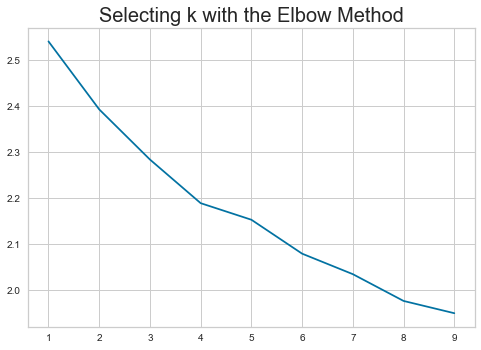

<IPython.core.display.Javascript object>

In [72]:
# Find the optimal number of clusters

clusters = range(1, 10)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_data)
    prediction = model.predict(subset_scaled_data)
    distortion = (
        sum(
            np.min(
                cdist(subset_scaled_data, model.cluster_centers_, "euclidean"), axis=1
            )
        )
        / subset_scaled_data.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.title("Selecting k with the Elbow Method", fontsize=20)

There appears to be a bend at 4.

I will try checking the silhouette scores.

For n_clusters = 2, silhouette score is 0.4606181717597457
For n_clusters = 3, silhouette score is 0.4682174791829737
For n_clusters = 4, silhouette score is 0.4596245690982079
For n_clusters = 5, silhouette score is 0.3938561719905606
For n_clusters = 6, silhouette score is 0.410787441159981
For n_clusters = 7, silhouette score is 0.40945225995045237
For n_clusters = 8, silhouette score is 0.4194579189033251
For n_clusters = 9, silhouette score is 0.1612244719249602


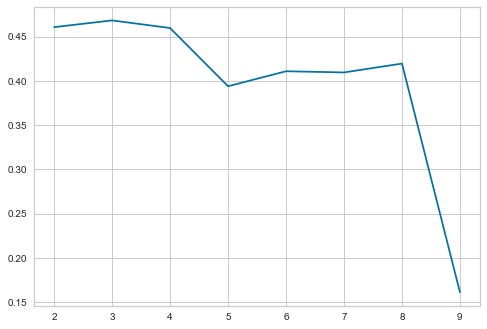

<IPython.core.display.Javascript object>

In [73]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_data))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_data, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

The silhouette score for 3 is the highest and 2 is the second highest.  I will review the Silhouette Visualizer for 3, 2 and 4 clusters.  

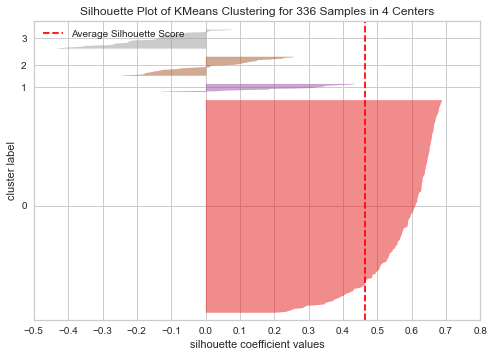

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 336 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [79]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(subset_scaled_data)
visualizer.show()

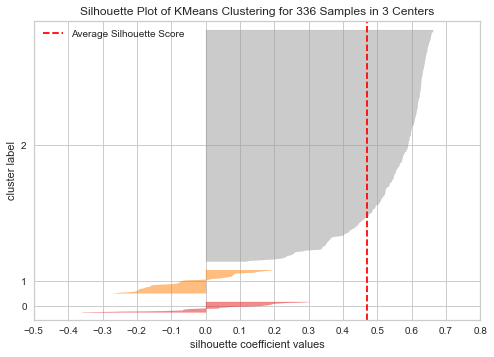

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 336 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [80]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(subset_scaled_data)
visualizer.show()

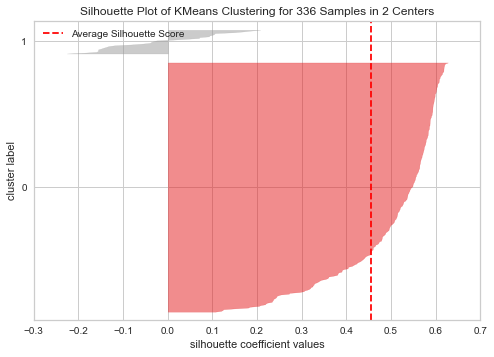

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 336 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [81]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(2, random_state=1))
visualizer.fit(subset_scaled_data)
visualizer.show()

None of these look optimal.  I will use 4 as the number of clusters because of the Elbow Method graph and the silhouette score was the third highest and the visualizer wasn't really any worse than the other three.

In [82]:
# Use 4 as the number of clusters
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(subset_scaled_data)

KMeans(n_clusters=4, random_state=0)

<IPython.core.display.Javascript object>

In [83]:
# Adding the cluster labels to the original dataset
data["KMeans_Segments"] = kmeans.labels_
subset_scaled_data["KMeans_Segments"] = kmeans.labels_

<IPython.core.display.Javascript object>

In [84]:
# Create a cluster profile using averages for each metric
cluster_profile = data.groupby("KMeans_Segments").mean()

<IPython.core.display.Javascript object>

In [85]:
# Add the count of stocks in each cluster to the profile
cluster_profile["Count_In_Each_Segment"] = (
    data.groupby("KMeans_Segments")["Security"].count().values
)

<IPython.core.display.Javascript object>

In [86]:
# Show the cluster and highlight the maximun value for each metric
cluster_profile.style.highlight_max(color="yellow", axis=0)

,Current_Price,Price_Change,Volatility,ROE,Cash_Ratio,Net_Cash_Flow,Net_Income,Earnings_Per_Share,Estimated_Shares_Outstanding,P/E_Ratio,P/B_Ratio,Count_In_Each_Segment
KMeans_Segments,,,,,,,,,,,,
0,243.226804,13.607350,1.742959,26.416667,285.083333,754548500.000000,976137166.666667,6.122917,567201602.563333,77.542325,15.041637,24
1,71.945866,5.078057,1.388294,32.597826,53.550725,61312666.666667,1544722579.710145,3.645924,442361681.594964,23.868059,-3.082032,276
2,39.455200,-14.791721,2.872588,114.360000,54.040000,-171366080.000000,-4165351320.000000,-10.048800,495905910.221600,90.421615,1.437355,25
3,50.517273,5.747586,1.130399,31.090909,75.909091,-1072272727.272727,14833090909.090910,4.154545,4298826628.727273,14.803577,-4.552119,11


<IPython.core.display.Javascript object>

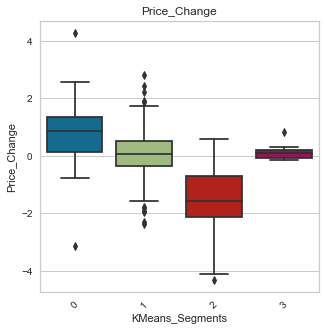

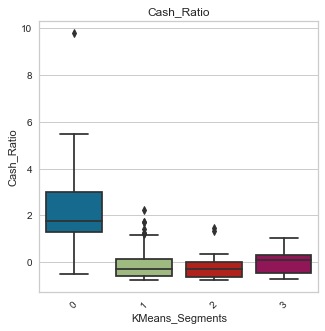

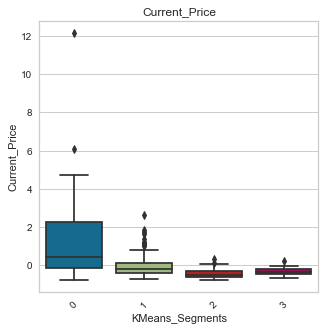

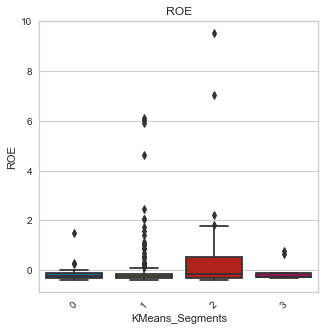

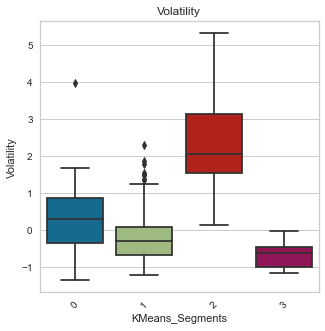

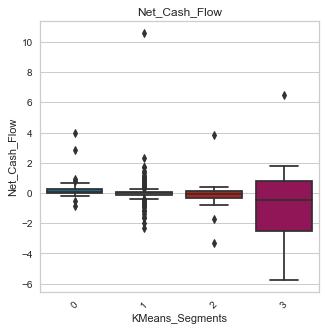

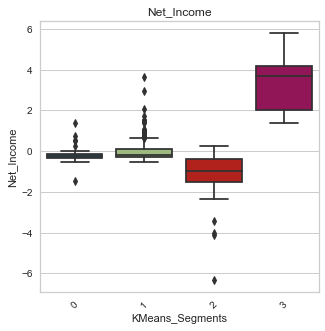

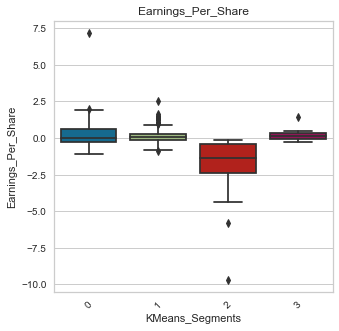

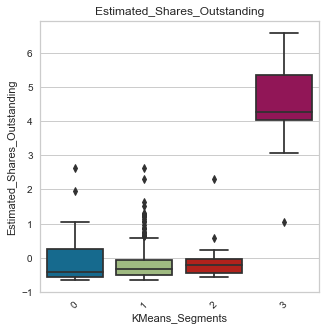

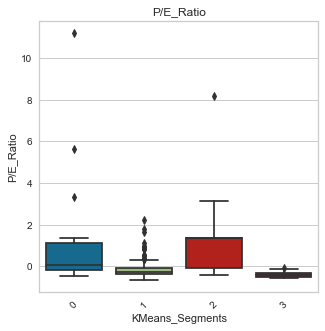

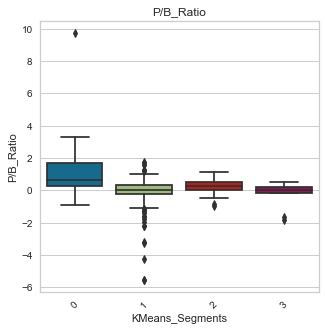

<IPython.core.display.Javascript object>

In [88]:
# Visualize the scaled numerical Variables by cluster

for i, variable in enumerate(cols):
    plt.subplots(nrows=1, sharex=False, figsize=(5, 5))
    sns.boxplot(x=subset_scaled_data["KMeans_Segments"], y=subset_scaled_data[variable])
    plt.xticks(rotation=45, fontsize=10)
    plt.title(variable)
plt.show()

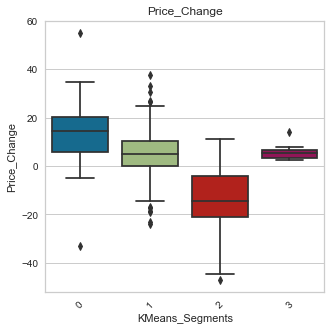

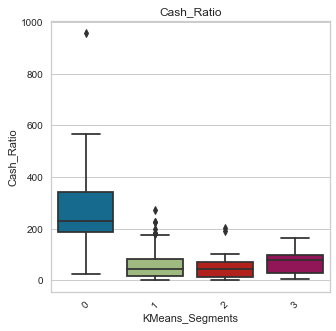

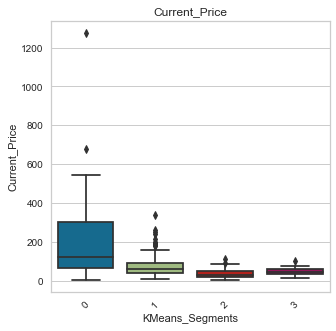

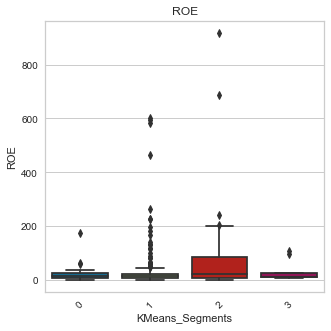

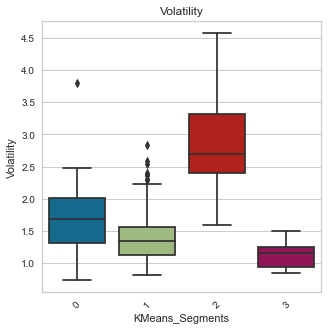

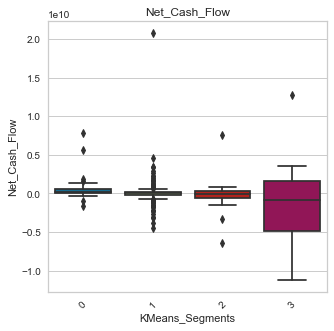

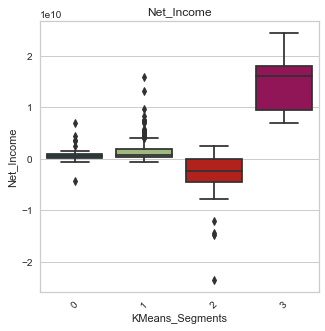

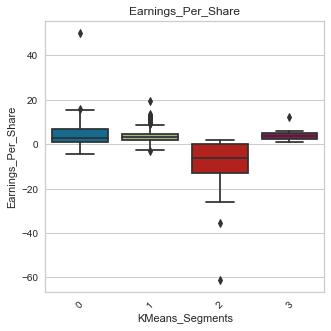

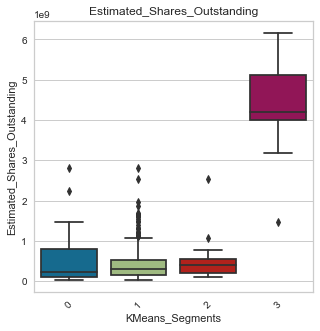

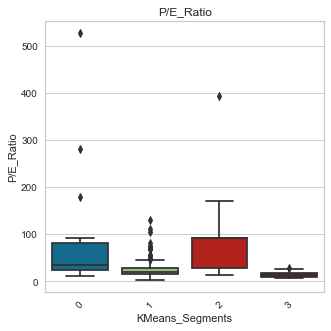

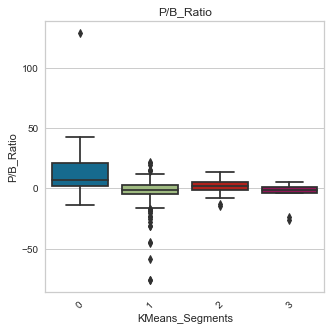

<IPython.core.display.Javascript object>

In [89]:
# Visualize the numerical variables by cluster

for i, variable in enumerate(cols):
    plt.subplots(nrows=1, sharex=False, figsize=(5, 5))
    sns.boxplot(x=data["KMeans_Segments"], y=data[variable])
    plt.xticks(rotation=45, fontsize=10)
    plt.title(variable)
plt.show()

#### Observations
* Cluster 0 has the highest average Current Price, Price Change, Cash Ratio, Net Cash Flow, Earnings Per Share, P/E and P/B Ratios.  
* Cluster 1 is the largest cluster.  It appears to have the largest
* Cluster 2 has the stocks with the highest average Volatility and ROE.  It includes the two companies with the highest ROE and has far and away the highest ROE.  However, the average ROE is likely a function of the two extreme ouliers in this group.  Given the volatility, this maybe a collection of the high risk stocks.
* Cluster 3 has the stocks with the highest average Net_Income and Estimated Shares Outstanding

In [152]:
# Compare cluster vs. GICS Sector
pd.crosstab(data.GICS_Sector, data.KMeans_Segments).style.highlight_max(
    color="yellow", axis=0
)

KMeans_Segments,0,1,2,3
GICS_Sector,,,,
Consumer Discretionary,6,32,0,1
Consumer Staples,1,17,0,1
Energy,1,6,20,1
Financials,0,46,0,3
Health Care,9,29,0,2
Industrials,0,52,1,0
Information Technology,5,24,3,1
Materials,0,19,1,0
Real Estate,1,26,0,0


<IPython.core.display.Javascript object>

It's not surpising that cluster 1 has the most of each GICS Sector.  However, it is interesting that our best performing cluster (cluster 0) is primarily made up of Healthcare, Information Technology and Consumer Discretionary stocks.  

I am going to try reducing the number of dimensions using t-SNE to see if that makes our clusters any more precise.

In [170]:
from sklearn.manifold import TSNE

# supress warnings
import warnings

warnings.filterwarnings("ignore")

tsne= TSNE(n_components=2, random_state=1)
K_reduced = tsne.fit_transform(subset_scaled_data)


<IPython.core.display.Javascript object>

In [154]:
K_reduced.shape

(336, 2)

<IPython.core.display.Javascript object>

In [155]:
reduced_data_df = pd.DataFrame(data=K_reduced, columns=["Component 1", "Component 2"])

<IPython.core.display.Javascript object>

In [156]:
reduced_data_df.head()

,Component 1,Component 2
0,7.221122,-11.693054
1,12.594016,-7.936826
2,10.228292,-5.335769
3,7.218289,5.535372
4,-8.458389,9.385371


<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='Component 1', ylabel='Component 2'>

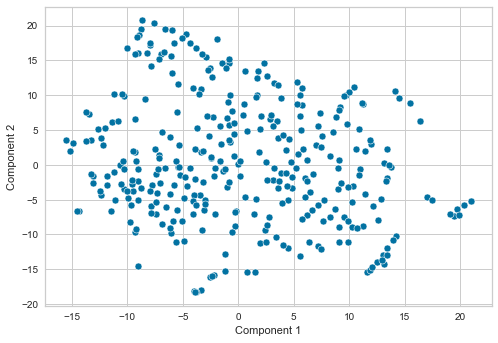

<IPython.core.display.Javascript object>

In [167]:
#Let's look at a scatterplot to see if this approach yeilded any clear groups
sns.scatterplot(x=reduced_data_df.iloc[:, 0], y=reduced_data_df.iloc[:, 1])

<AxesSubplot:xlabel='Component 1', ylabel='Component 2'>

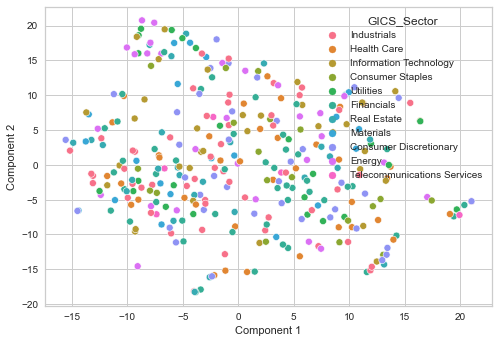

<IPython.core.display.Javascript object>

In [164]:
# Let's graph by GICS Sector to see if a pattern emerges
sns.scatterplot(
    x=reduced_data_df.iloc[:, 0],
    y=reduced_data_df.iloc[:, 1],
    hue=data.GICS_Sector,
)

It doesn't appear to me that dimension reduction offers any improvement to our clustering process.

## Hierarchical Clustering

In [91]:
# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to compute distances
from scipy.spatial.distance import pdist

<IPython.core.display.Javascript object>

In [92]:
# Create a subset of my data that excludes the KMeans Segment so it doesn't impact the hierarchical cluster analysis
hcdata = data.copy()

<IPython.core.display.Javascript object>

In [93]:
hcdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336 entries, 0 to 339
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Security                      336 non-null    object 
 1   GICS_Sector                   336 non-null    object 
 2   GICS_Sub_Industry             336 non-null    object 
 3   Current_Price                 336 non-null    float64
 4   Price_Change                  336 non-null    float64
 5   Volatility                    336 non-null    float64
 6   ROE                           336 non-null    int64  
 7   Cash_Ratio                    336 non-null    int64  
 8   Net_Cash_Flow                 336 non-null    int64  
 9   Net_Income                    336 non-null    int64  
 10  Earnings_Per_Share            336 non-null    float64
 11  Estimated_Shares_Outstanding  336 non-null    float64
 12  P/E_Ratio                     336 non-null    float64
 13  P/B_R

<IPython.core.display.Javascript object>

In [94]:
hcdata.drop("KMeans_Segments", axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [95]:
hcdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336 entries, 0 to 339
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Security                      336 non-null    object 
 1   GICS_Sector                   336 non-null    object 
 2   GICS_Sub_Industry             336 non-null    object 
 3   Current_Price                 336 non-null    float64
 4   Price_Change                  336 non-null    float64
 5   Volatility                    336 non-null    float64
 6   ROE                           336 non-null    int64  
 7   Cash_Ratio                    336 non-null    int64  
 8   Net_Cash_Flow                 336 non-null    int64  
 9   Net_Income                    336 non-null    int64  
 10  Earnings_Per_Share            336 non-null    float64
 11  Estimated_Shares_Outstanding  336 non-null    float64
 12  P/E_Ratio                     336 non-null    float64
 13  P/B_R

<IPython.core.display.Javascript object>

In [113]:
# scaling the dataset before clustering
scaler = StandardScaler()
hcsubset = hcdata[num_col].copy()
hcsubset_scaled = scaler.fit_transform(hcsubset)

<IPython.core.display.Javascript object>

In [114]:
hcsubset_scaled_data = pd.DataFrame(hcsubset_scaled, columns=subset.columns)

<IPython.core.display.Javascript object>

In [115]:
# list distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list linkage methods
linkage_methods = [
    "single",
    "complete",
    "average",
    "weighted",
]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(hcsubset_scaled_data, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(hcsubset_scaled_data))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.9267600020885861.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8306302287224043.
Cophenetic correlation for Euclidean distance and average linkage is 0.9425353899345458.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8846333268441363.
Cophenetic correlation for Chebyshev distance and single linkage is 0.9099918754628888.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8319658175631209.
Cophenetic correlation for Chebyshev distance and average linkage is 0.9327201840497188.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.9153242211059153.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.9288921048726622.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.7748302398828738.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.9306714946876986.
Cophenetic co

<IPython.core.display.Javascript object>

In [116]:
# Print the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9425353899345458, which is obtained with Euclidean distance and average linkage.


<IPython.core.display.Javascript object>

In [117]:
# Explore additional linkage methods using the Euclidean distance
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(hcsubset_scaled_data, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(hcsubset_scaled_data))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.9267600020885861.
Cophenetic correlation for complete linkage is 0.8306302287224043.
Cophenetic correlation for average linkage is 0.9425353899345458.
Cophenetic correlation for centroid linkage is 0.9344302888354984.
Cophenetic correlation for ward linkage is 0.6403095432717979.
Cophenetic correlation for weighted linkage is 0.8846333268441363.


<IPython.core.display.Javascript object>

I still get the highest cophenetic correlation using the average linkage and the Euclidean distance.  It a good number, but I will graph the dendrograms for the different linkage methods.

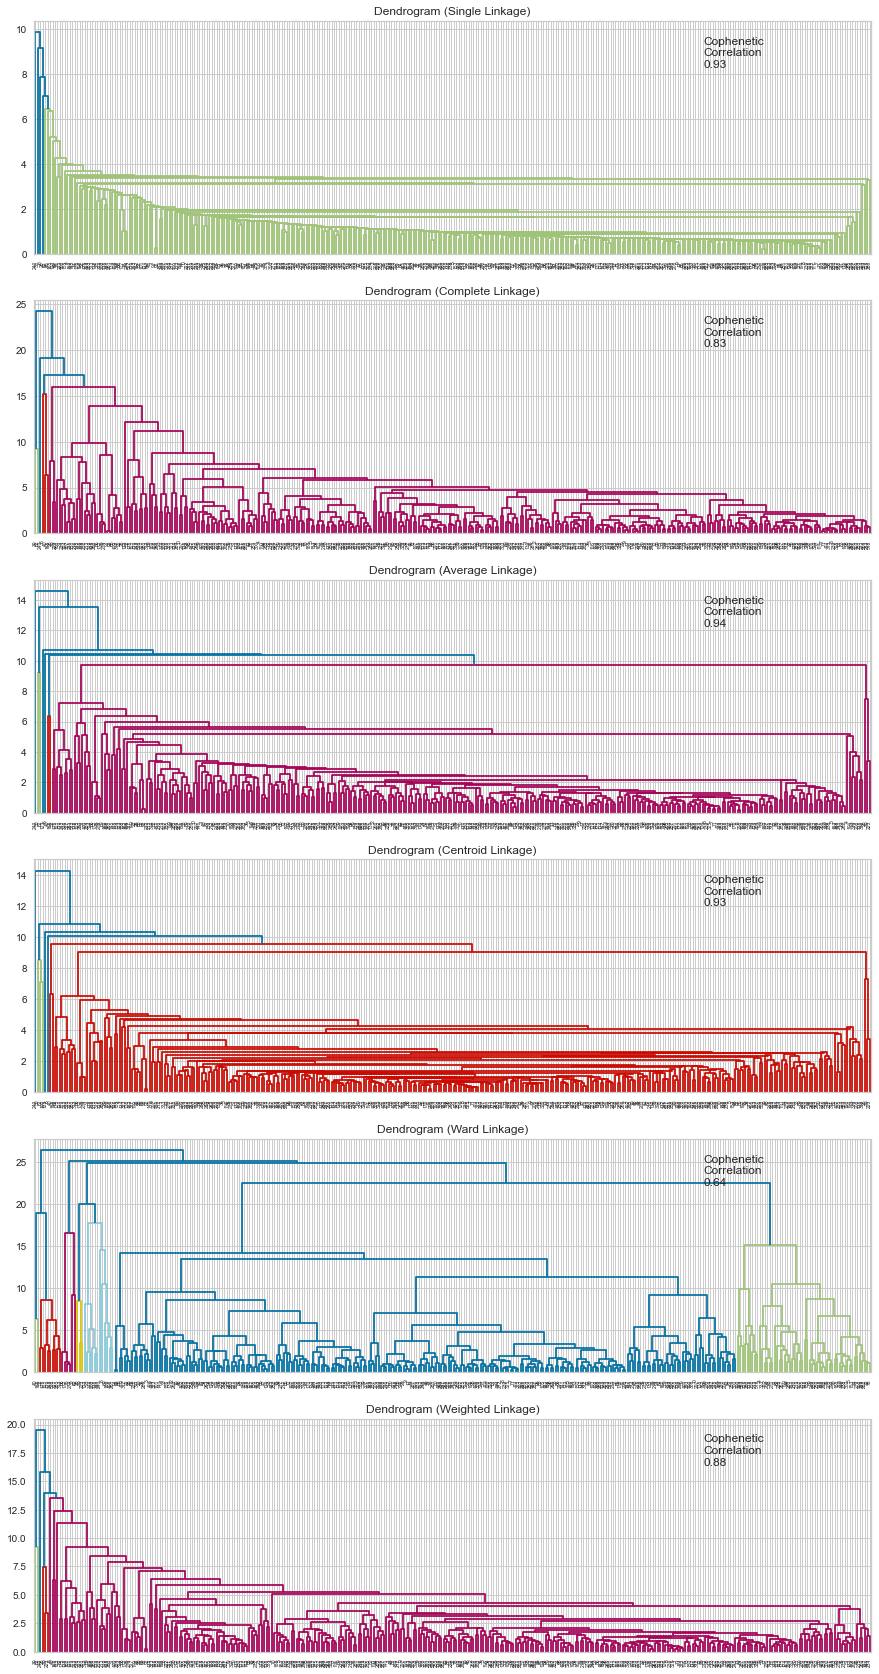

<IPython.core.display.Javascript object>

In [118]:
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(hcsubset_scaled_data, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(hcsubset_scaled_data))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])

The dendrogram for Ward linkage seems to show the most distinct clusters.
I will try the Chebyshev, Mahalanobis and Cityblock distances with single and average linkage methods because they gave high cophenetic correlation values.

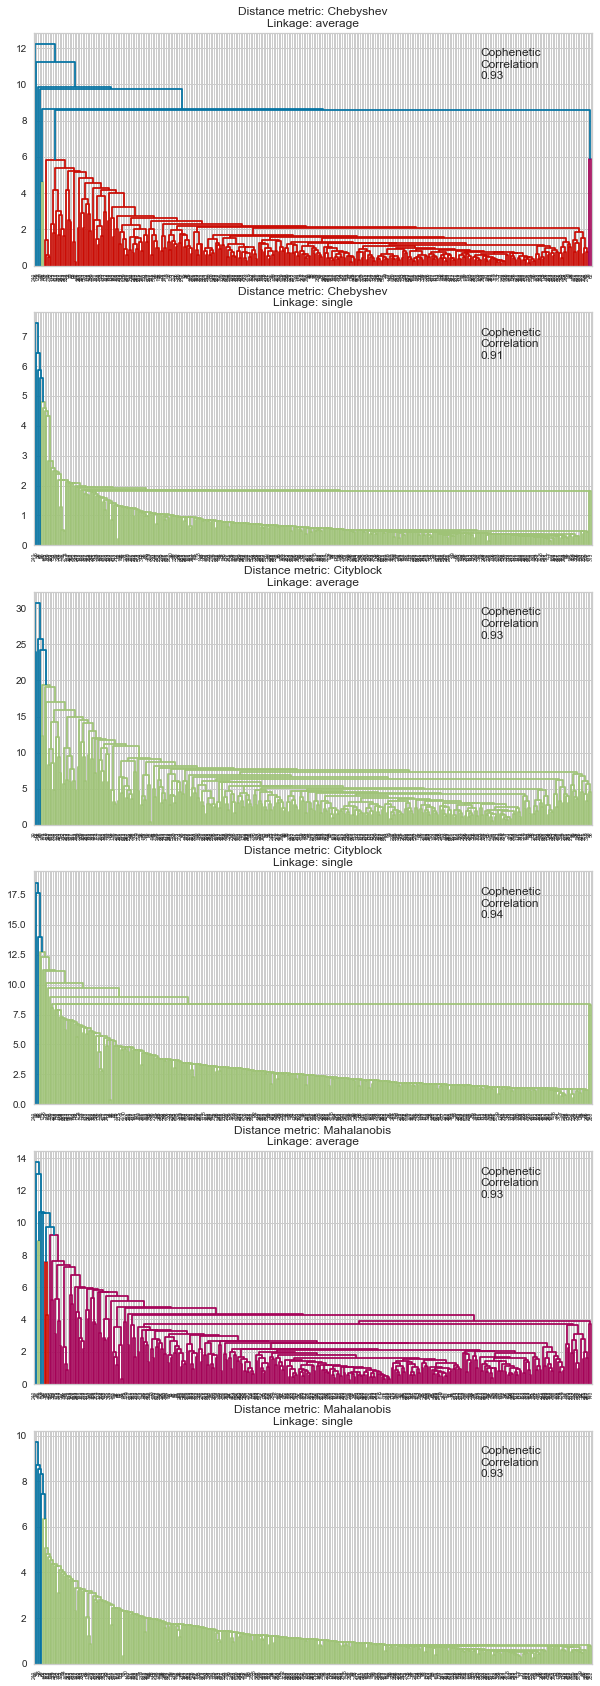

<IPython.core.display.Javascript object>

In [119]:
distance_metrics = ["chebyshev", "cityblock", "mahalanobis"]

# linkage methods
linkage_methods = ["average", "single"]

# to create a subplot image
fig, axs = plt.subplots(
    len(distance_metrics) + len(distance_metrics), 1, figsize=(10, 30)
)

i = 0
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(hcsubset_scaled_data, metric=dm, method=lm)

        dendrogram(Z, ax=axs[i])
        axs[i].set_title("Distance metric: {}\nLinkage: {}".format(dm.capitalize(), lm))

        coph_corr, coph_dist = cophenet(Z, pdist(hcsubset_scaled_data))
        axs[i].annotate(
            f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
            (0.80, 0.80),
            xycoords="axes fraction",
        )
        i += 1

Of all the dendrograms created, the Ward linkage method using the Euclidean distance provided the most distinct set of clusters.  I will use the Ward linkage method and 6 for the number of clusters.

In [120]:
HCmodel = AgglomerativeClustering(n_clusters=6, affinity="euclidean", linkage="ward")
HCmodel.fit(hcsubset_scaled_data)

AgglomerativeClustering(n_clusters=6)

<IPython.core.display.Javascript object>

In [121]:
# Add the HC cluster labels to the original and scaled data sets
hcsubset_scaled_data["HC_Clusters"] = HCmodel.labels_
data["HC_Clusters"] = HCmodel.labels_

<IPython.core.display.Javascript object>

In [122]:
# Review the HC Clusters
hc_cluster_profile = data.groupby("HC_Clusters").mean()

<IPython.core.display.Javascript object>

In [123]:
# Add the HC Cluster counts
hc_cluster_profile["Count_Cluster"] = (
    data.groupby("HC_Clusters")["Security"].count().values
)

<IPython.core.display.Javascript object>

In [124]:
#  Display the HC Cluster Profile
hc_cluster_profile.style.highlight_max(color="pink", axis=0)

,Current_Price,Price_Change,Volatility,ROE,Cash_Ratio,Net_Cash_Flow,Net_Income,Earnings_Per_Share,Estimated_Shares_Outstanding,P/E_Ratio,P/B_Ratio,KMeans_Segments,Count_Cluster
HC_Clusters,,,,,,,,,,,,,
0,42.848182,6.270446,1.123547,22.727273,71.454545,558636363.636364,14631272727.272728,3.410000,4242572567.290909,15.242169,-4.924615,2.818182,11
1,325.996105,7.724708,1.545762,17.000000,360.333333,186503166.666667,1008736416.666667,9.544167,589434517.801667,41.121871,25.258283,0.000000,12
2,67.898334,3.897726,1.849292,641.000000,39.166667,-663466666.666667,-5751016666.666667,-12.243333,445943436.900000,45.861986,-0.834572,1.333333,6
3,63.136482,-10.848891,2.117329,34.518519,72.870370,101307351.851852,-752546518.518519,-1.280741,412839314.782778,56.472302,2.662141,1.370370,54
4,72.222036,7.026323,1.387282,26.624000,56.840000,27939004.000000,1640132300.000000,3.744140,462314469.895520,22.732839,-3.501963,0.976000,250
5,327.006671,21.917380,2.029752,4.000000,106.000000,698240666.666667,287547000.000000,0.750000,366763235.300000,400.989188,-5.322376,0.666667,3


<IPython.core.display.Javascript object>

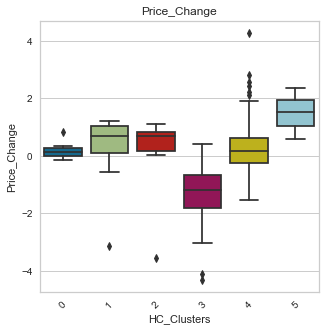

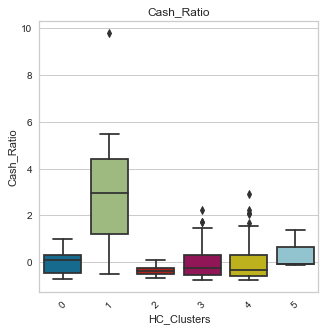

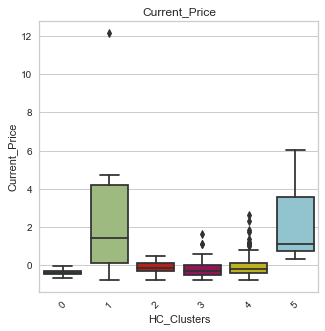

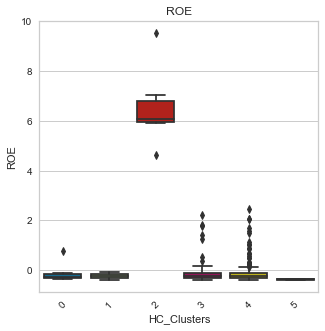

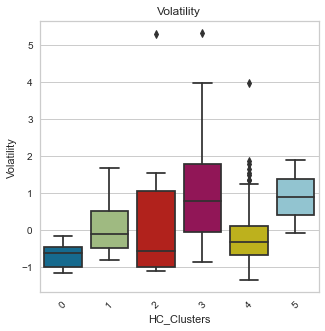

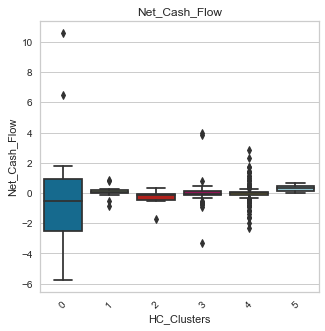

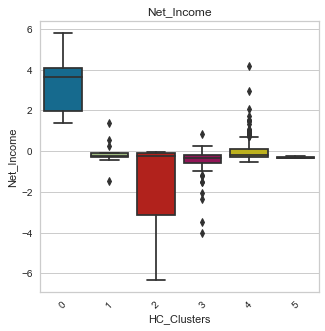

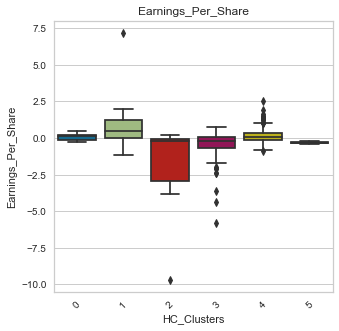

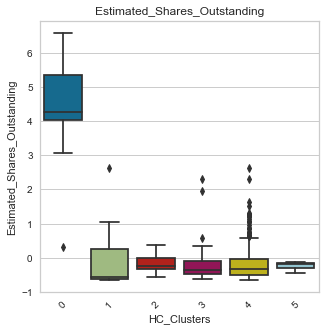

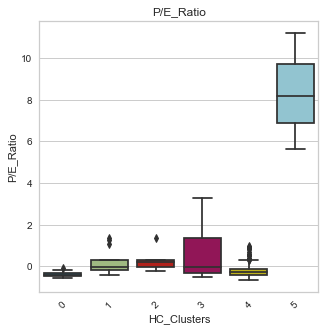

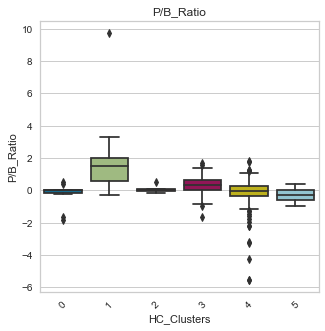

<IPython.core.display.Javascript object>

In [126]:
# Visualize the scaled numerical variables by HC Cluster

for i, variable in enumerate(cols):
    plt.subplots(nrows=1, sharex=False, figsize=(5, 5))
    sns.boxplot(x=hcsubset_scaled_data["HC_Clusters"], y=hcsubset_scaled_data[variable])
    plt.xticks(rotation=45, fontsize=10)
    plt.title(variable)
plt.show()

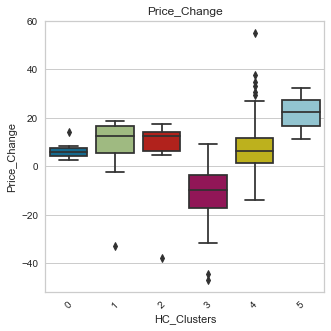

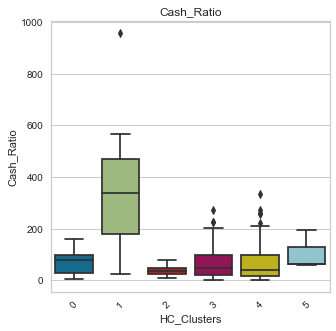

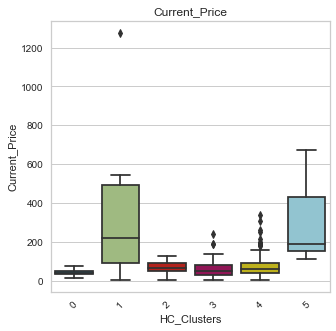

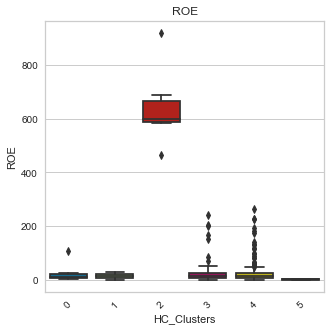

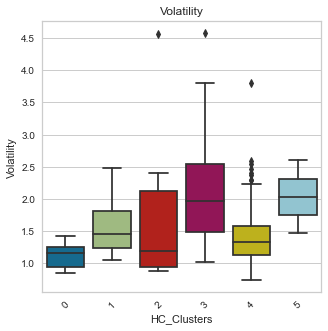

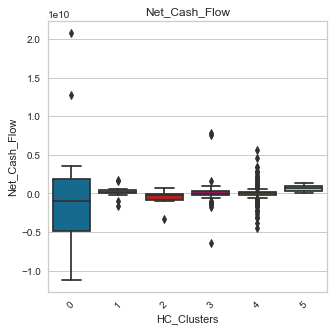

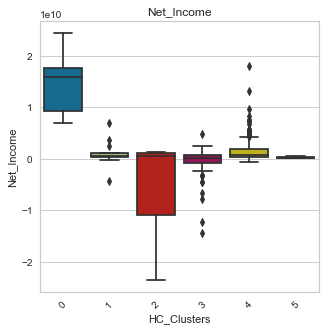

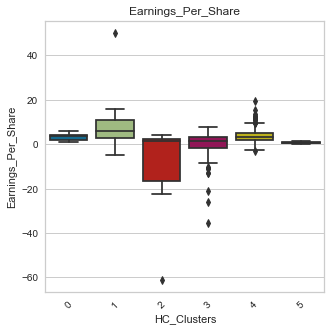

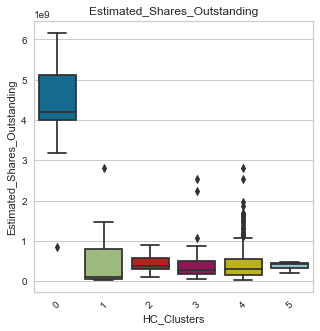

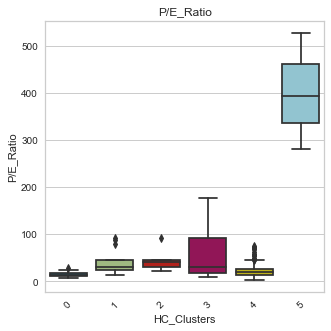

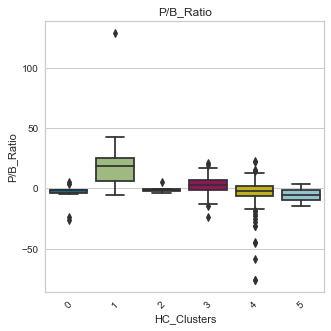

<IPython.core.display.Javascript object>

In [127]:
# Visualize the original numerical variables by HC Cluster

for i, variable in enumerate(cols):
    plt.subplots(nrows=1, sharex=False, figsize=(5, 5))
    sns.boxplot(x=data["HC_Clusters"], y=data[variable])
    plt.xticks(rotation=45, fontsize=10)
    plt.title(variable)
plt.show()

#### Observations
* Cluster 0 has the highest average Net Income and Outstanding Shares
* Cluster 1 has the highest average Cash Ratio, Earnings Per Share and P/B Ratio
* Cluster 2 has the highest average ROE, by far and the lowest ROE in that cluster is higher than the ROE of all the stocks in the other clusters
* Cluster 3 has the highest volatility
* Cluster 4 has the highest number of stocks.  It seems to be the catch all.
* Cluster 5 has the highest Current Price, Price Change, Net Cash Flow and P/E Ratio.   The P/E Ratio is far and away the highest of all the groups.  Stocks within this group have a P/E Ratio far and away above the P/E Ratio for all the other stocks in our data set.  The stocks within the group are really pretty volatile with the volatility being second only to cluster 3 and it's close.


In [149]:
# Compare HC Clusters by GICS Sector
pd.crosstab(data.GICS_Sector, data.HC_Clusters).style.highlight_max(
    color="yellow", axis=0
)

HC_Clusters,0,1,2,3,4,5
GICS_Sector,,,,,,
Consumer Discretionary,1,2,0,4,31,1
Consumer Staples,1,1,2,1,14,0
Energy,1,0,2,20,5,0
Financials,4,0,1,2,42,0
Health Care,1,4,0,6,28,1
Industrials,0,0,1,7,45,0
Information Technology,1,3,0,7,21,1
Materials,0,0,0,5,15,0
Real Estate,0,1,0,2,24,0


<IPython.core.display.Javascript object>

## K-means vs Hierarchical Clustering

Neither the KMeans nor the HC analysis yeilded an obvious optimal number of clusters.   KMeans generated 4 clusters with fairly distinct characteristics and HC generated 6 clusters with some distinguishing characteristics.  The KMeans clusters seem more useful to me.  While I was disappointed that there was such a large number of stocks dumped in the catch all cluster that had no distinguishing characteristics, the KMeans cluster analysis did yeild a short list of stocks with characteristics that are useful in the development of a stock portfolio.  There were some similiarities between the HC groups and the KMeans groups but overall the KMeans clusters were more distinct.

## Actionable Insights and Recommendations

Using KMeans clustering we have identified a set of growth stocks to be used for investors seeking to maximize their returns. We also identified a set of stocks that should yield a return with less riskas well as a population of inexpensive, high risk stocks with the potential for high returns.

In order to provide a balanced portfolio, Trade&Ahead needs to be able to select stocks with both growth potential and less risky stocks that will still yield a return.  By narrowing down the population of stocks to several in each of the two categories noted above, Trade&Ahead will be able to customize an individual’s portfolio based on their risk profile.  There are a few different economic sectors represented in the growth and lower risk clusters.  This will enable the advisor to build a portfolio that meets an individual's risk profile as well as diversify that portfolio against economic downturns in any one market segment.  

In addition, we have identified a list of high risk stocks for investors who may have an appetite for riskier investments with the potential for very high returns.  Stocks on this list may require additional research to ensure the proper fit with the investor, but this short list provides a starting point for that analysis.

To enhance the clustering process it would be helpful to have some additional historical data.  It was unclear if the metrics provided were specific to the most recent year or reporting period.  These financial metrics captured over a 5 year period would help to smooth out any recent ticks in these metrics and would likely be more indicative of the overall management strategy.  

Additionally, the management team at a company drives these financial measures and therefore we recommend including the length of tenor of the management team in the list of attributes.   While this doesn’t ensure consistency, a change in management likely impacts whether or not the current performance will be continued.

There are of course other considerations when choosing stocks that are not interpretable from the financial metrics provided.  An informed investment analyst with both company specific and industry knowledge is not to be eliminated.
